# FlexzBoost on cosmoDC2 French vs Sam

<span style="font-size:22px;"> Author: Iago Lopes Soares Dias<br>
Email: iagolops2012@gmail.com</span>


<span style="font-size:20px;"> The objective of this notebook is to evaluate FlexzBoost on simulated data of LSST, more specifically cosmo DC2 data that came from PZ French WG and from Sam. </span>
<span style="font-size:20px;"> If you just want to check the results, you can skip to "Results" section.</span>

## Importing packages

In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables_io
import qp
import sys


from matplotlib import gridspec
import seaborn as sns
from qp.metrics.pit import PIT
from IPython.display import Markdown
import h5py
import os
from qp.ensemble import Ensemble
from qp import interp


from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator
from rail.evaluation.metrics.base import MetricEvaluator
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle, DataHandle, Hdf5Handle
from rail.core.util_stages import ColumnMapper, TableConverter
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.point_est_hist import PointEstHistSummarizer
from rail.estimation.algos.var_inf import VarInfStackSummarizer
from rail.evaluation.metrics.cdeloss import *
from qp.metrics.pit import PIT

import warnings
warnings.filterwarnings("ignore")


In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

# Selecting the data and analysing

## Functions to analyze

### plot_errors

In [3]:
def plot_errors(catalog):
    bands = ['u', 'g', 'r', 'i', 'z', 'y']
    j=1
    plt.figure(figsize=[9,13])
    for i, band in enumerate(bands):

        plt.subplot(3,2,j) 
        mag = np.array(catalog[f'mag_{band}_lsst'])
        err = np.array(catalog[f'mag_err_{band}_lsst'])
        sn = 1/(10**(0.4*err)-1)
        plt.hexbin(mag,sn , None, mincnt=1, cmap='inferno', gridsize=[400,200], bins='log')
        cbar = plt.colorbar()
        plt.ylabel("S/R ", fontsize=13)
        plt.xlabel("mag "+band, fontsize=13)
        plt.ylim(0,100)
        plt.xlim(20,30)
        plt.axhline(10, color= 'red')
        plt.grid(True)
        j+=1
        plt.tight_layout()

### mag_histogram

In [4]:
def mag_histogram(catalog, title='DP0.2'):
    
    bands = ['u','g', 'r', 'i', 'z','y']
    colors = ['blue', 'green', 'orange','red','purple','gray']
    plt.figure(figsize=(9,13))
    bins = np.linspace(9, 37, 57)
    j=1
    for i, (band, color) in enumerate(zip(bands,colors)):
        plt.subplot(3,2,j)
        plt.hist(catalog[f'mag_{band}_lsst'], histtype='stepfilled', bins=bins, label=f'{band} band', alpha = 0.5,
                 edgecolor = "black", color = color)
        #plt.xlim(16,27)
        plt.yscale('log')
        plt.xlabel('mag',fontsize=13)
        plt.ylabel('counts',fontsize=13)
        plt.legend(loc=2)
        plt.grid(True)
        j+=1
    plt.suptitle(title,fontsize=16)
    plt.show()


### mag_color

In [5]:
def mag_color(catalog,title=''):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    mag_diff = {}
    plt.figure(figsize=(9,13))
    i=1
    for band,_band in zip(bands, bands[1::]):
        plt.subplot(3,2,i)
        i+=1
        mag_diff_v = catalog[f'mag_{band}_lsst']-catalog[f'mag_{_band}_lsst']
        mag_v = catalog[f'mag_{band}_lsst'] 
                   
        plt.hexbin(mag_v, mag_diff_v, None, mincnt=1, cmap='Reds', gridsize=[400,200], bins='log')

        plt.xlabel("mag "+band,fontsize=13)
        plt.ylabel(f"{band}-{_band}",fontsize=13)
        #plt.legend()
        plt.xlim(16,32)
        plt.ylim(-2,5)
        plt.grid(True)
        plt.suptitle(title,fontsize=16)
        plt.tight_layout()
    plt.show()

### color_color

In [6]:
def cor_cor(catalog,title=''):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        plt.hist2d(past_color-color,color-next_color, bins = 100, cmap='turbo' )
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        #plt.axvline(0)
        #plt.axhline(0)
        plt.suptitle(title,fontsize=16)
    plt.show()

In [7]:
def color_color(catalog,title=''):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(past_color-color,color-next_color, None, mincnt=1, cmap='turbo', gridsize=[400,400], bins='log')
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar()
        plt.xlim(-1,3)
        plt.ylim(-1,3)
        plt.suptitle(title,fontsize=16)
    plt.show()

In [8]:
def color_color_red(catalog,xlim=[-1,3],ylim=[-1,3],title=''):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(past_color-color,color-next_color, C=catalog['redshift'], mincnt=1, cmap='turbo', gridsize=[400,400])
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar(label='redshift')
        plt.xlim(xlim[0],xlim[1])
        plt.ylim(ylim[0],ylim[1])
        plt.suptitle(title,fontsize=16)
    plt.show()

## Reading data

The data used here comes from the DESC PZ Working Group. We don't now if the reddening was removed.

In [9]:
french = pd.read_csv('/home/iago/ic_cosmo/samples/sample_cosmodc2_w10year_errors.dat', sep =' ')

french.drop('dec',axis=1,inplace=True)



In [10]:
sam_test =  tables_io.read('/home/iago/ic_cosmo/samples/cosmodc2_460k_i26_5_testset.hdf5')['photometry']
sam_train = tables_io.read('/home/iago/ic_cosmo/samples/cosmodc2_halfhealpix_i26_5_training.hdf5')['photometry']

In [11]:
columns_map = {
    "#id": "redshift",
    "ra": "dec", 
    "sz": "ra",
    "u": "mag_u_lsst",
    "uerr": "mag_err_u_lsst",
    "g": "mag_g_lsst",
    "gerr": "mag_err_g_lsst",
    "r": "mag_r_lsst",
    "rerr": "mag_err_r_lsst",
    "i": "mag_i_lsst",
    "ierr": "mag_err_i_lsst",
    "y": "mag_y_lsst",
    "yerr": "mag_err_y_lsst",
    "z": "mag_z_lsst",
    "zerr": "mag_err_z_lsst",
    "galid": "galid"
}
french = french.rename(columns=columns_map)


In [12]:
sam_train = pd.DataFrame(sam_train)
sam_test = pd.DataFrame(sam_test)

In [13]:
french

redshift         ra        dec  mag_u_lsst  mag_err_u_lsst  \
0           0.0220  62.584977 -40.334110     17.6159          0.0050   
100         0.0489  62.737951 -40.310046     19.3351          0.0051   
200         0.0258  61.679292 -41.217925     23.0562          0.0144   
300         0.0292  62.836708 -40.058639     23.7464          0.0251   
400         0.0336  62.349167 -40.069310     23.1186          0.0151   
...            ...        ...        ...         ...             ...   
10409900    2.8531  65.820556 -37.911725     27.6754          0.8820   
10410000    2.8760  67.040719 -38.408924     28.2485          1.4946   
10410100    2.9215  66.338044 -38.558236     26.7672          0.3827   
10410200    3.0305  66.287684 -38.883792     29.0782          3.2079   
10410300    2.9476  65.884390 -39.271043     25.8659          0.1675   

          mag_g_lsst  mag_err_g_lsst  mag_r_lsst  mag_err_r_lsst  mag_i_lsst  \
0            16.3943          0.0050     15.9683          0.0050     15.7529   
100          18.0216          0.0050     17.4491          0.0050     17.1498   
200          21.9222          0.0053     21.5337          0.0051     21.3164   
300          22.4624          0.0057     21.8373          0.0051     21.5111   
400          22.0724          0.0054     21.7829          0.0051     21.6102   
...              ...             ...         ...             ...         ...   
10409900     25.8391          0.0488     25.4753          0.0307     25.2173   
10410000     25.4134          0.0334     25.0840          0.0217     25.1027   
10410100     25.0215          0.0237     24.7763          0.0167     24.8933   
10410200     25.3102          0.0305     25.1340          0.0227     25.2163   
10410300     24.7771          0.0193     24.5671          0.0141     24.5893   

          mag_err_i_lsst  mag_z_lsst  mag_err_z_lsst  mag_y_lsst  \
0                 0.0050     15.6386          0.0050     15.5775   
100               0.0050     16.9570          0.0050     16.8299   
200               0.0052     21.2373          0.0055     21.1947   
300               0.0053     21.3566          0.0056     21.2626   
400               0.0053     21.5308          0.0059     21.5019   
...                  ...         ...             ...         ...   
10409900          0.0455     25.1953          0.0900     25.0288   
10410000          0.0410     25.0662          0.0800     25.3066   
10410100          0.0340     24.8028          0.0628     24.8250   
10410200          0.0454     25.4343          0.1121     25.5566   
10410300          0.0259     24.7606          0.0604     24.6250   

          mag_err_y_lsst       galid      Av  
0                 0.0050 -2147483648  0.0655  
100               0.0050 -2147483648  0.0980  
200               0.0085 -2147483648  0.1502  
300               0.0089 -2147483648  0.2221  
400               0.0105 -2147483648  0.1636  
...                  ...         ...     ...  
10409900          0.2364 -2147483648  0.0000  
10410000          0.3053 -2147483648  0.2084  
10410100          0.1960 -2147483648  0.1290  
10410200          0.3843 -2147483648  0.0070  
10410300          0.1630 -2147483648  1.2032  

[104104 rows x 17 columns]

In [14]:
sam_train

gr    gr_err           id        iz    iz_err  mag_err_g_lsst  \
0       0.435994  0.007072   1250000000  0.164345  0.007072        0.005001   
1       0.439835  0.012676   1250000225  0.090141  0.014104        0.010262   
2       0.330523  0.008828   1250000450  0.039524  0.009960        0.006645   
3       0.427570  0.009876   1250000675  0.102930  0.010689        0.007698   
4       0.686884  0.007932   1250000900  0.181633  0.007676        0.005943   
...          ...       ...          ...       ...       ...             ...   
467511  0.113300  0.158715  12082698485  0.019361  0.245783        0.122208   
467512  0.611593  0.197180  12082702112  0.185627  0.207731        0.174618   
467513  0.038696  0.197801  12082705368 -0.068195  0.394990        0.147949   
467514  0.184448  0.135202  12082813708 -0.298508  0.308424        0.106793   
467515  0.166254  0.227262  12083087639  0.390142  0.297576        0.178392   

        mag_err_i_lsst  mag_err_r_lsst  mag_err_u_lsst  mag_err_y_lsst  ...  \
0             0.005000        0.005000        0.005017        0.005001  ...   
1             0.008135        0.007441        0.131178        0.023148  ...   
2             0.006154        0.005813        0.056329        0.014314  ...   
3             0.006572        0.006186        0.073198        0.015032  ...   
4             0.005278        0.005254        0.052234        0.007050  ...   
...                ...             ...             ...             ...  ...   
467511        0.122385        0.101269       26.620825        0.678206  ...   
467512        0.115517        0.091588       26.620825        0.233439  ...   
467513        0.184823        0.131287        1.218981        1.359921  ...   
467514        0.121504        0.082916       26.620825        0.635525  ...   
467515        0.186907        0.140799        1.357517        0.860943  ...   

        mag_u_lsst  mag_y_lsst  mag_z_lsst  redshift        ri    ri_err  \
0        17.062208   15.137871   15.244094  0.014800  0.259352  0.007071   
1        24.718765   22.663742   22.714552  0.048879  0.233574  0.011025   
2        23.789845   22.090605   22.109261  0.047392  0.184605  0.008465   
3        24.079102   22.151592   22.242300  0.072630  0.224634  0.009025   
4        23.706137   20.985334   21.085735  0.066845  0.348433  0.007447   
...            ...         ...         ...       ...       ...       ...   
467511   99.000000   26.366076   26.015394  2.939646  0.197647  0.158850   
467512   99.000000   25.207281   25.786221  3.063382  0.150948  0.147420   
467513   27.144945   27.121641   26.551600  2.998359  0.031853  0.226707   
467514   99.000000   26.295479   26.325401  3.032414 -0.012690  0.147100   
467515   27.261883   26.625195   26.105455  3.016731  0.095812  0.234006   

               ug     ug_err        zy    zy_err  
0        0.958424   0.007083  0.106223  0.007072  
1        1.240664   0.131579  0.050810  0.025856  
2        1.125933   0.056719  0.018656  0.016316  
3        1.081667   0.073602  0.090708  0.017235  
4        1.403452   0.052571  0.100401  0.008988  
...           ...        ...       ...       ...  
467511  72.654297  26.621105 -0.350681  0.710911  
467512  72.265610  26.621399  0.578939  0.290347  
467513   0.590992   1.227926 -0.570042  1.404010  
467514  72.801346  26.621040  0.029922  0.695884  
467515   0.504219   1.369188 -0.519739  0.891538  

[467516 rows x 24 columns]

In [15]:
sam_test

gr    gr_err           id        iz    iz_err  mag_err_g_lsst  \
0       0.670420  0.007072   1312500000  0.193890  0.007071        0.005001   
1       0.315699  0.007944   1312500225  0.077675  0.008477        0.005824   
2       0.174147  0.033231   1312500450  0.122187  0.047875        0.026059   
3       0.275715  0.013911   1312500675  0.048395  0.018623        0.010965   
4       0.434650  0.056377   1312500900  0.127439  0.064814        0.047869   
...          ...       ...          ...       ...       ...             ...   
459879  0.321768  0.152475  12020227767 -0.303936  0.248236        0.125821   
459880  0.403038  0.175803  12020231248 -0.284409  0.463913        0.148396   
459881  0.745779  0.215683  12020282535 -0.130091  0.372210        0.195672   
459882  0.136423  0.204941  12020553074 -1.089359  0.850464        0.159157   
459883  0.224892  0.182998  12020819041  0.154181  0.321155        0.146542   

        mag_err_i_lsst  mag_err_r_lsst  mag_err_u_lsst  mag_err_y_lsst  ...  \
0             0.005000        0.005000        0.005026        0.005001  ...   
1             0.005575        0.005403        0.033321        0.009905  ...   
2             0.025786        0.020620        0.306728        0.097963  ...   
3             0.010116        0.008561        0.123833        0.032323  ...   
4             0.034883        0.029781        0.498633        0.127012  ...   
...                ...             ...             ...             ...  ...   
459879        0.097429        0.086126       20.088198        0.948325  ...   
459880        0.184665        0.094263        0.785022        0.705715  ...   
459881        0.166510        0.090727        0.828054        0.502770  ...   
459882        0.172251        0.129111        2.759413        0.804818  ...   
459883        0.174971        0.109607        0.716050        3.163353  ...   

        mag_u_lsst  mag_y_lsst  mag_z_lsst  redshift        ri    ri_err  \
0        17.491247   14.687290   14.804871  0.015425  0.354918  0.007071   
1        23.202431   21.592501   21.638060  0.030609  0.185198  0.007763   
2        25.644894   24.262041   24.195457  0.045475  0.147116  0.033017   
3        24.655771   23.041840   23.107073  0.065590  0.142187  0.013252   
4        26.173477   24.545084   24.529957  0.065404  0.227051  0.045866   
...            ...         ...         ...       ...       ...       ...   
459879   30.187891   26.730179   26.090155  2.999858  0.269466  0.130039   
459880   26.666809   26.409260   26.766876  2.991169 -0.328266  0.207332   
459881   26.724800   26.040960   26.499992  2.994675 -0.257412  0.189624   
459882   28.032347   26.551975   27.496140  2.969296  0.090273  0.215267   
459883   26.566866   28.038321   26.269642  2.982220 -0.105167  0.206467   

              ug     ug_err        zy    zy_err  
0       1.467150   0.007090  0.117580  0.007072  
1       0.985800   0.033827  0.045559  0.011785  
2       1.005987   0.307833 -0.066584  0.105942  
3       1.082401   0.124318  0.065233  0.035906  
4       0.854380   0.500925 -0.015127  0.138261  
...          ...        ...       ...       ...  
459879  3.810438  20.088593 -0.640024  0.975423  
459880  0.109570   0.798925  0.357616  0.824104  
459881 -0.133469   0.850859  0.459032  0.602986  
459882  1.398870   2.763999  0.944164  1.158167  
459883  0.023319   0.730892 -1.768679  3.174796  

[459884 rows x 24 columns]

In [16]:
catalog = pd.concat([french,sam_test,sam_train],ignore_index=True)
sam = pd.concat([sam_test,sam_train])

In [17]:
catalog

redshift         ra        dec  mag_u_lsst  mag_err_u_lsst  \
0        0.022000  62.584977 -40.334110   17.615900        0.005000   
1        0.048900  62.737951 -40.310046   19.335100        0.005100   
2        0.025800  61.679292 -41.217925   23.056200        0.014400   
3        0.029200  62.836708 -40.058639   23.746400        0.025100   
4        0.033600  62.349167 -40.069310   23.118600        0.015100   
...           ...        ...        ...         ...             ...   
1031499  2.939646        NaN        NaN   99.000000       26.620825   
1031500  3.063382        NaN        NaN   99.000000       26.620825   
1031501  2.998359        NaN        NaN   27.144945        1.218981   
1031502  3.032414        NaN        NaN   99.000000       26.620825   
1031503  3.016731        NaN        NaN   27.261883        1.357517   

         mag_g_lsst  mag_err_g_lsst  mag_r_lsst  mag_err_r_lsst  mag_i_lsst  \
0         16.394300        0.005000   15.968300        0.005000   15.752900   
1         18.021600        0.005000   17.449100        0.005000   17.149800   
2         21.922200        0.005300   21.533700        0.005100   21.316400   
3         22.462400        0.005700   21.837300        0.005100   21.511100   
4         22.072400        0.005400   21.782900        0.005100   21.610200   
...             ...             ...         ...             ...         ...   
1031499   26.345703        0.122208   26.232403        0.101269   26.034756   
1031500   26.734388        0.174618   26.122795        0.091588   25.971848   
1031501   26.553953        0.147949   26.515257        0.131287   26.483404   
1031502   26.198652        0.106793   26.014204        0.082916   26.026894   
1031503   26.757664        0.178392   26.591410        0.140799   26.495598   

         ...    gr_err            id        iz    iz_err        ri    ri_err  \
0        ...       NaN           NaN       NaN       NaN       NaN       NaN   
1        ...       NaN           NaN       NaN       NaN       NaN       NaN   
2        ...       NaN           NaN       NaN       NaN       NaN       NaN   
3        ...       NaN           NaN       NaN       NaN       NaN       NaN   
4        ...       NaN           NaN       NaN       NaN       NaN       NaN   
...      ...       ...           ...       ...       ...       ...       ...   
1031499  ...  0.158715  1.208270e+10  0.019361  0.245783  0.197647  0.158850   
1031500  ...  0.197180  1.208270e+10  0.185627  0.207731  0.150948  0.147420   
1031501  ...  0.197801  1.208271e+10 -0.068195  0.394990  0.031853  0.226707   
1031502  ...  0.135202  1.208281e+10 -0.298508  0.308424 -0.012690  0.147100   
1031503  ...  0.227262  1.208309e+10  0.390142  0.297576  0.095812  0.234006   

                ug     ug_err        zy    zy_err  
0              NaN        NaN       NaN       NaN  
1              NaN        NaN       NaN       NaN  
2              NaN        NaN       NaN       NaN  
3              NaN        NaN       NaN       NaN  
4              NaN        NaN       NaN       NaN  
...            ...        ...       ...       ...  
1031499  72.654297  26.621105 -0.350681  0.710911  
1031500  72.265610  26.621399  0.578939  0.290347  
1031501   0.590992   1.227926 -0.570042  1.404010  
1031502  72.801346  26.621040  0.029922  0.695884  
1031503   0.504219   1.369188 -0.519739  0.891538  

[1031504 rows x 28 columns]

### Removing 99 values

In [18]:
bands = ['u','g','r','i','z','y']

for band in bands:
    # 99 values
    sam_train = sam_train[sam_train[f'mag_{band}_lsst']<99]
    sam_test = sam_test[sam_test[f'mag_{band}_lsst']<99]
    french = french[french[f'mag_{band}_lsst']<99]
    sam = sam[sam[f'mag_{band}_lsst']<99]
    

## Plotting the data and analysing

### Plot error

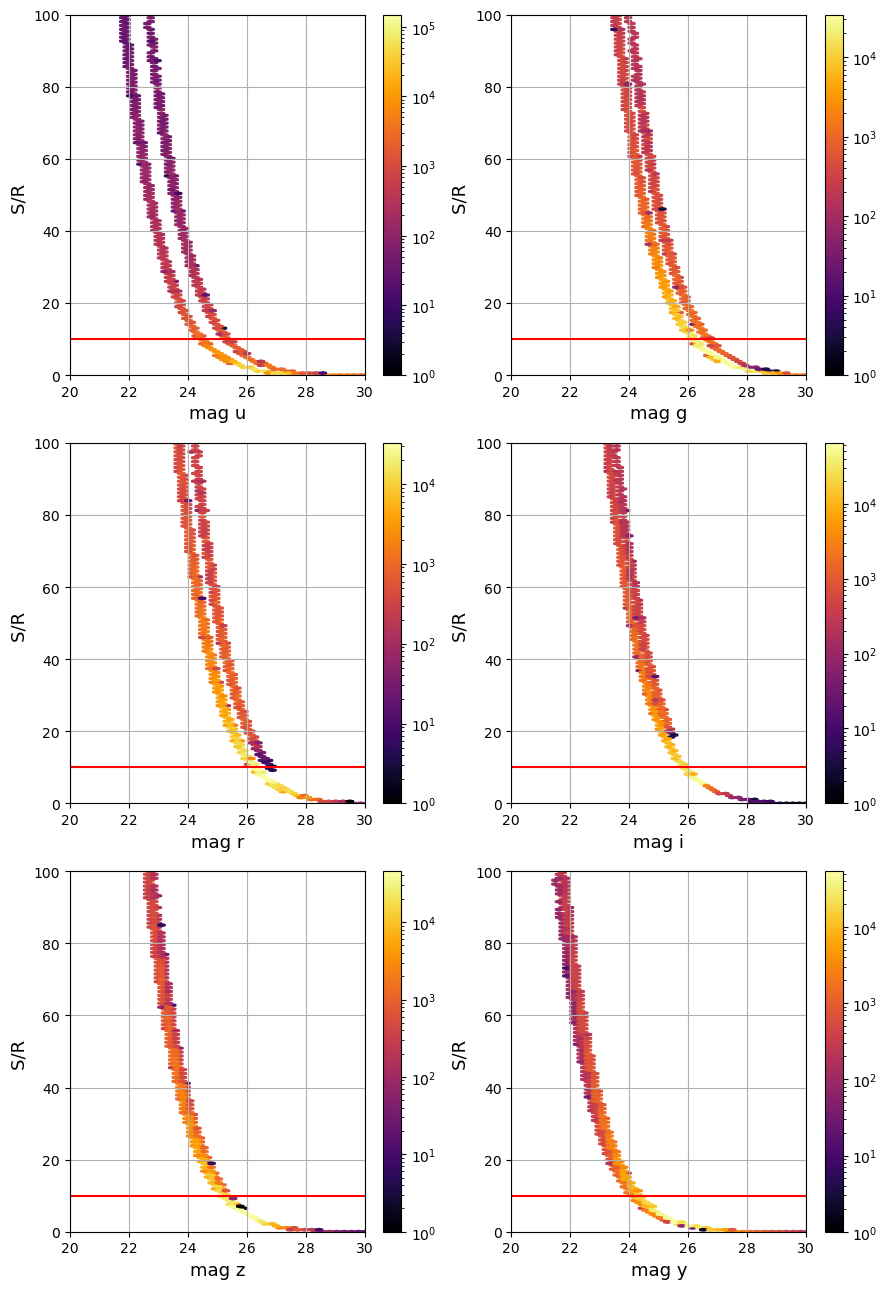

In [19]:
plot_errors(catalog)

### Plot mag hist

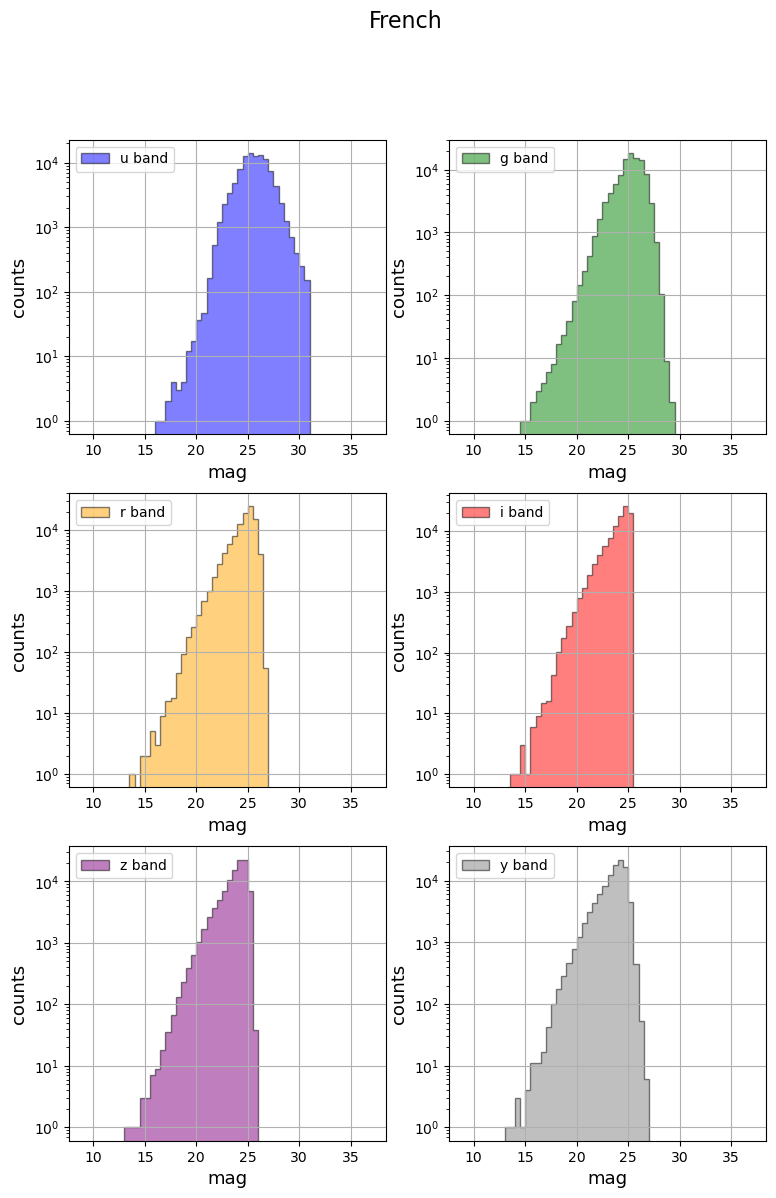

In [21]:
mag_histogram(french,title='French')

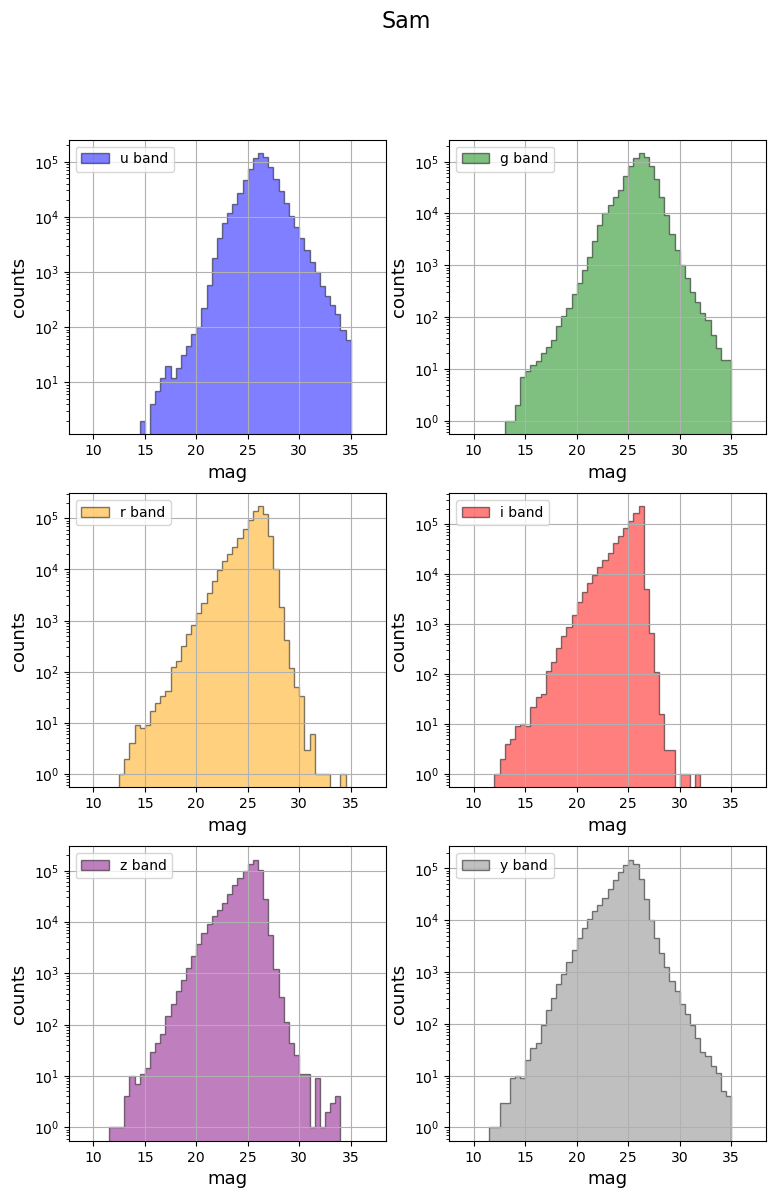

In [22]:
mag_histogram(sam,title='Sam')

### Plot mag x color

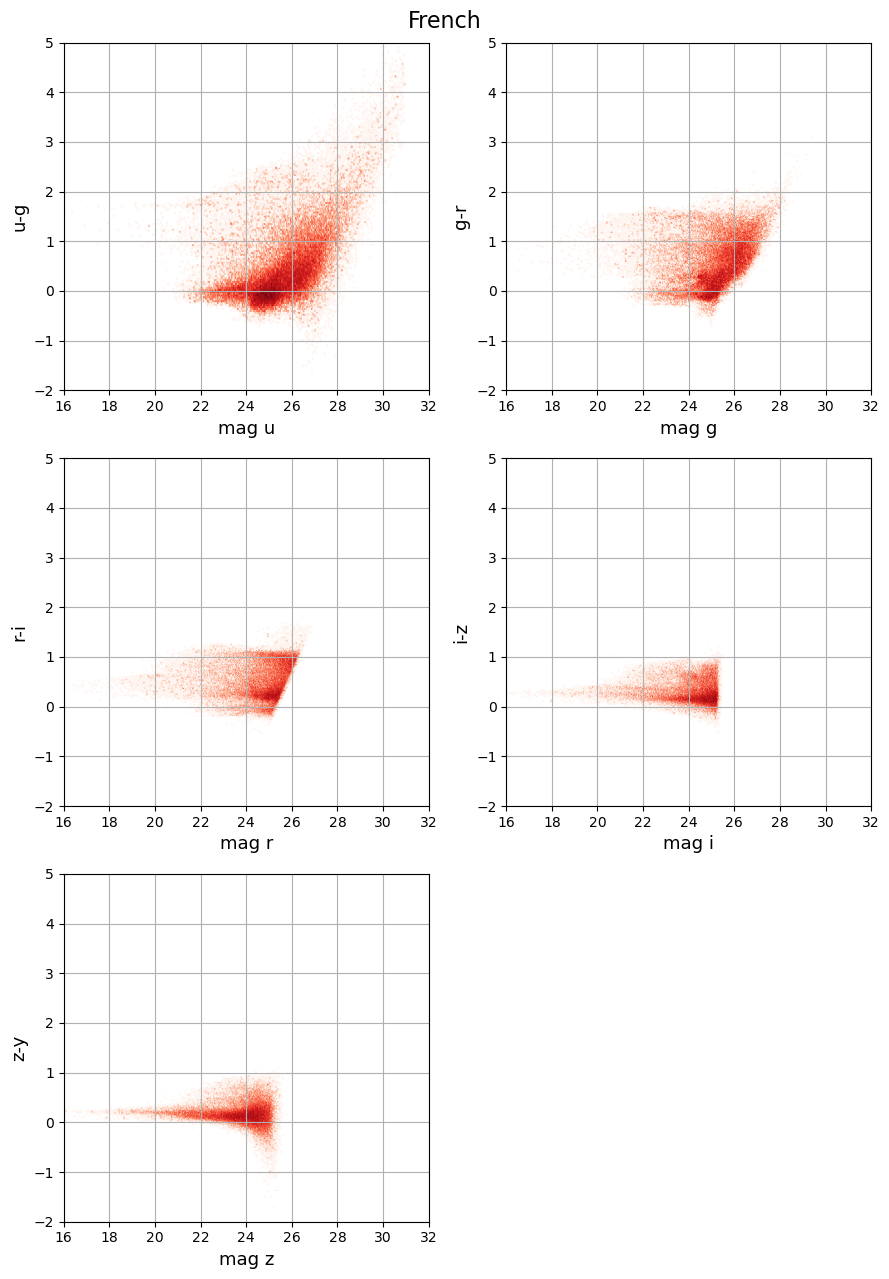

In [23]:
mag_color(french,title='French')

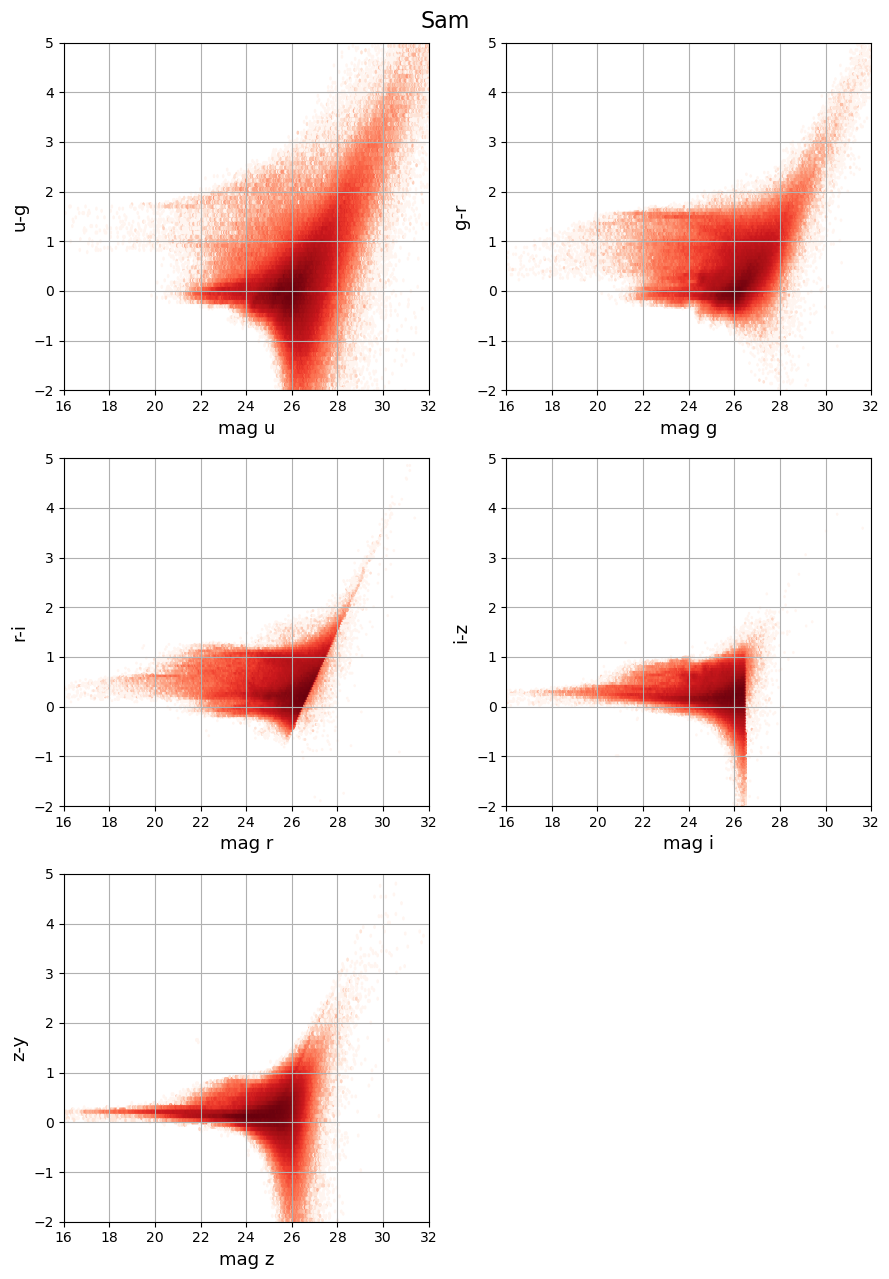

In [24]:
mag_color(sam,title='Sam')

### Plot color x color

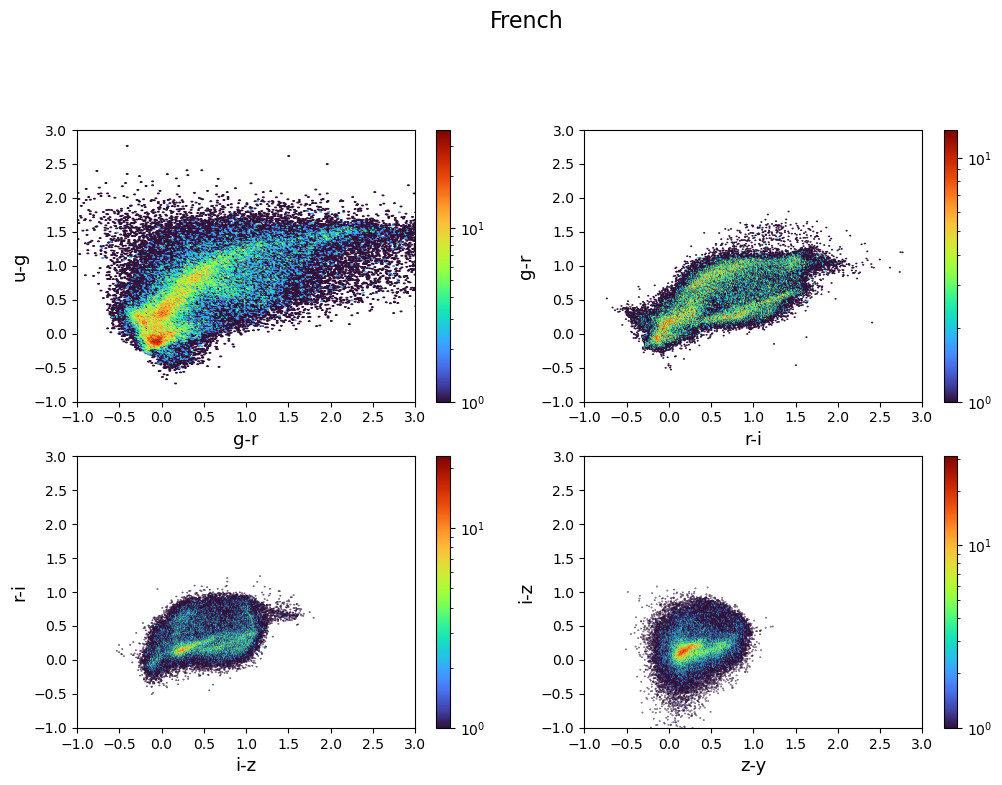

In [25]:
color_color(french,title='French') 

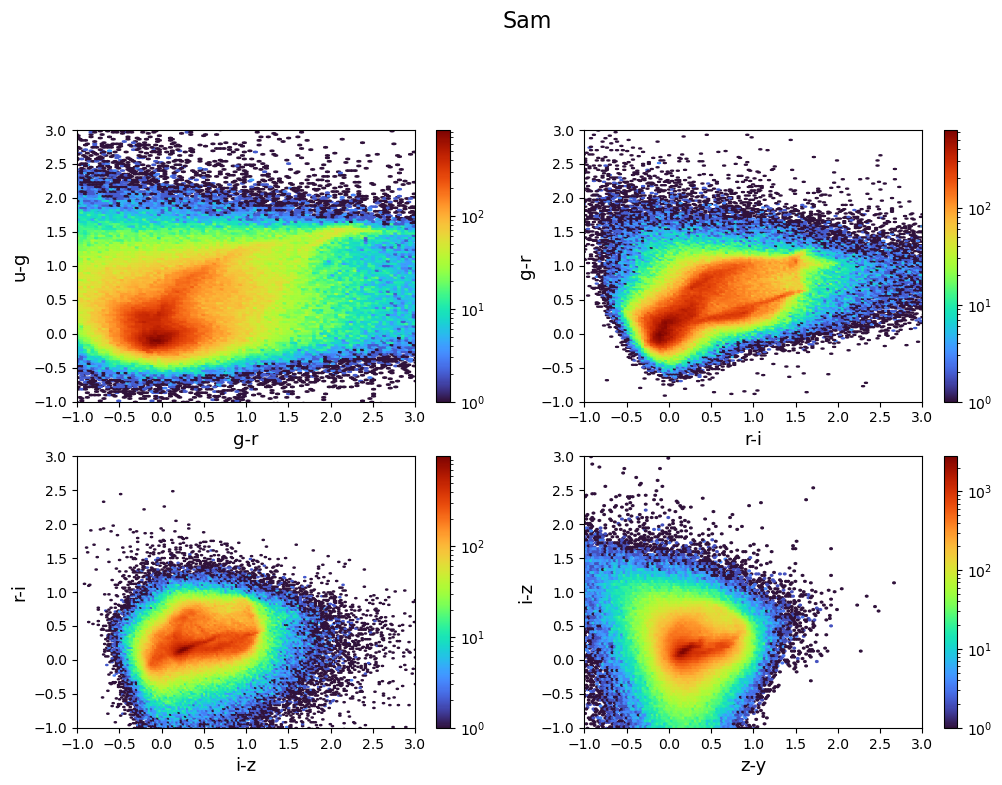

In [26]:
color_color(sam,title='Sam') 

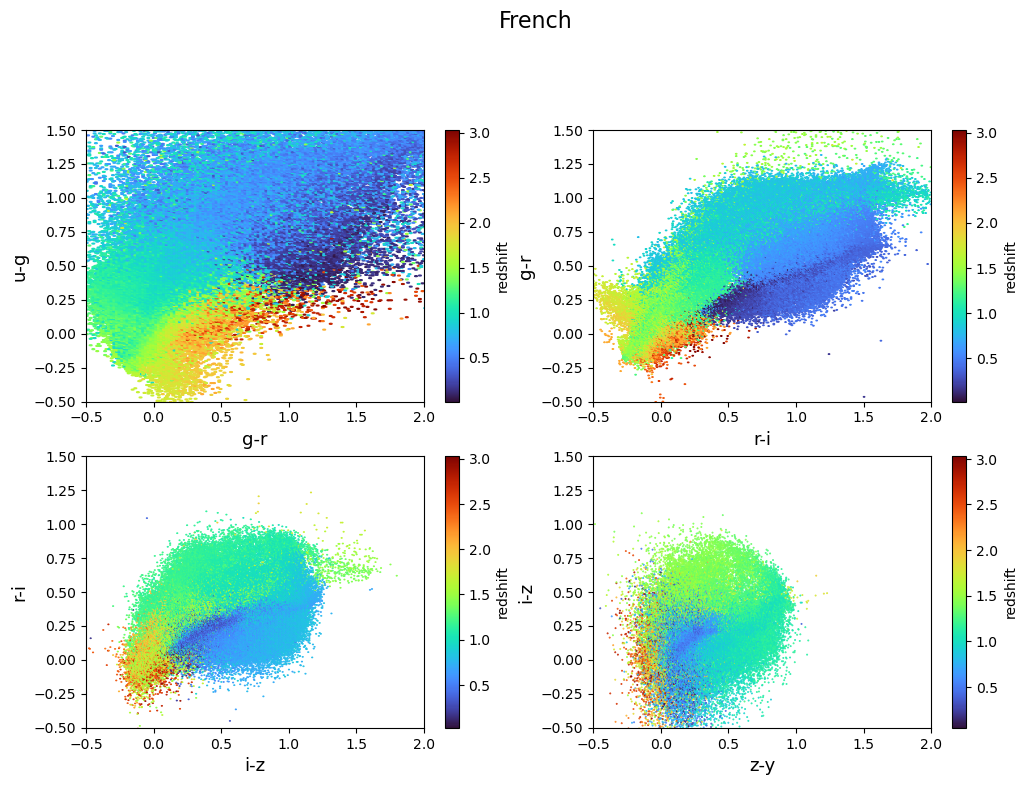

In [27]:
color_color_red(french,[-0.5,2],[-0.5,1.5],title='French')

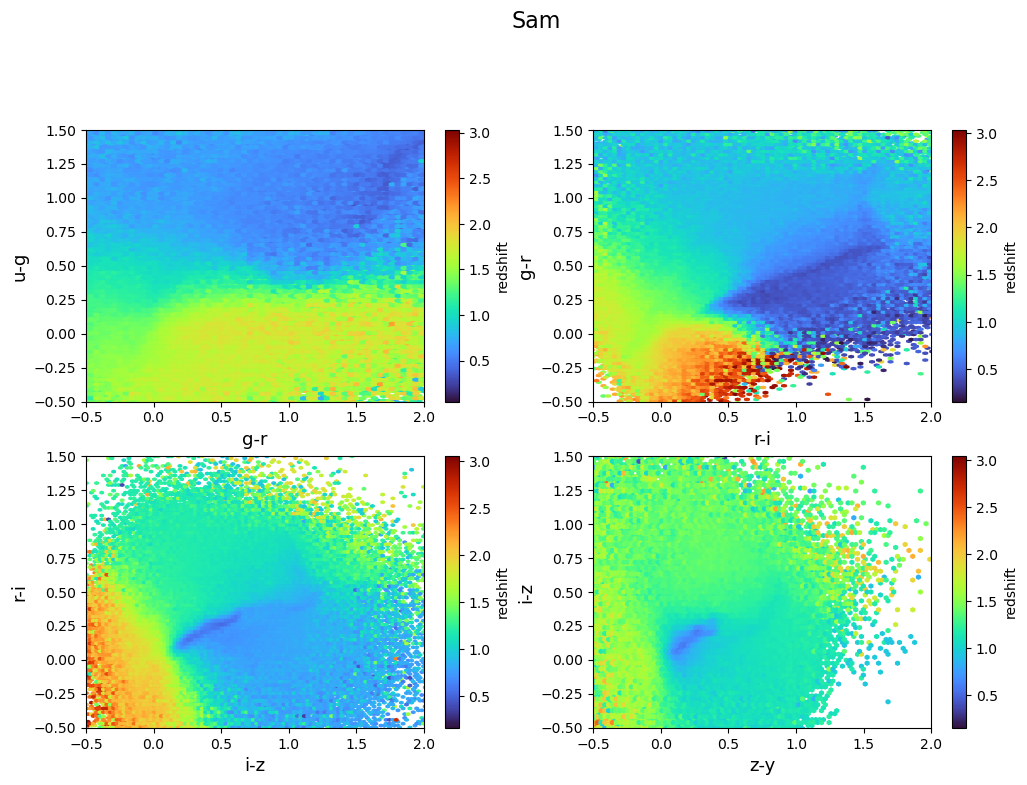

In [28]:
color_color_red(sam,[-0.5,2],[-0.5,1.5],title='Sam')

Text(0, 0.5, 'DEC')

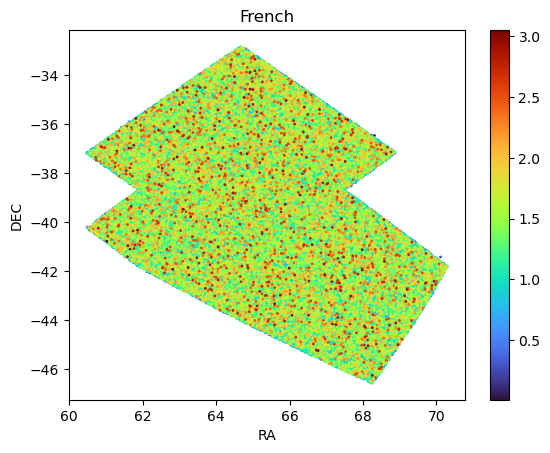

In [28]:
plt.scatter(french['ra'],french['dec'], c=french['redshift'],cmap='turbo',s=1)
plt.colorbar()
plt.title('French')
plt.xlabel('RA')
plt.ylabel('DEC')
#plt.xlim(64,68)
#plt.ylim(-40,-34)

## Dividing in training and testing with cuts

In [19]:
sam_train_o=sam_train
sam_test_o=sam_test
french_o=french

In [20]:

# i band
i_band=25
sam_train = sam_train_o[sam_train_o['mag_i_lsst']<i_band]
sam_test = sam_test_o[sam_test_o['mag_i_lsst']<i_band]
french = french_o[french_o['mag_i_lsst']<i_band]
sam = sam[sam['mag_i_lsst']<i_band]

print(f'French: {len(french)}')
print(f'Sam: {len(sam)}')

French: 81080
Sam: 268102


In [21]:
len(sam)==len(sam_train)+len(sam_test)

True

In [22]:
fraction_french = 0.5
fraction_sam = np.round(len(sam_test)/len(sam),2)

french_train = french.sample(round(len(french)*fraction_french),random_state=40)
french_test = french.drop(french_train.index)

## Changing the data to a PqHandle

In [23]:
french_train_sample = DS.add_data(data=french_train, handle_class=PqHandle, key='redshift')
sam_train_sample = DS.add_data(data=sam_train, handle_class=PqHandle, key='redshift')

In [24]:
french_test_sample = DS.add_data(data=french_test, handle_class=PqHandle, key='redshift')
sam_test_sample = DS.add_data(data=sam_test, handle_class=PqHandle, key='redshift')

In [25]:
print(f'Train French: {len(french_train_sample.data)}')
print(f'Test French: {len(french_test_sample.data)}')
print(f'Train Sam: {len(sam_train_sample.data)}')
print(f'Test Sam: {len(sam_test_sample.data)}')

Train French: 40540
Test French: 40540
Train Sam: 135211
Test Sam: 132891


## Getting the maximum and minimum redshift from training sample for FlexzBoost configurations

In [26]:

z_max_french = max(french_train['redshift'])
z_min_french = min(french_train['redshift'])
print(z_max_french)
z_max_sam = max(sam_train['redshift'])
z_min_sam = min(sam_train['redshift'])
print(z_max_sam)

3.0509
3.0451567840441056


# Configuring algorithm, training and validating

## Setting FlexzBoost

Here we can change the configurations of the algorithm.

List of possible regressions:
reg:squarederror // reg:linear // reg:pseudohubererror // reg:absoluteerror

In [29]:
limits_french = []  # selecting the magnitude limits of each band for FlexzBoost settings
limits_sam = [] 
for band in ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst']:
    limits_french.append(np.round(max(french_train_sample.data[band]),2))
    limits_sam.append(np.round(max(sam_train_sample.data[band]),2))
print(f'Limits French: {limits_french}')
print(f'Limits Sam: {limits_sam}')

Limits French: [28.48, 26.56, 25.0, 25.27, 26.08]
Limits Sam: [29.45, 26.86, 25.0, 25.4, 26.01]


In [30]:
############################ FlexzBoost configurations #########################################

basis_system = 'Fourier'
reg = 'squarederror'
max_basis = 35
depth = 8 
dataset = 'French'

################################################################################################

fz_dict_french = dict(zmin=z_min_french, zmax=z_max_french, nzbins=201,
               trainfrac=fraction_french, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=max_basis, basis_system= basis_system,
               bands = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
               err_bands = ['mag_err_u_lsst','mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
               mag_limits={'mag_u_lsst':limits_french[0],'mag_g_lsst':limits_french[1],'mag_r_lsst':limits_french[2],'mag_i_lsst':limits_french[3],'mag_z_lsst':limits_french[4],
                           'mag_y_lsst':limits_french[5],},
               hdf5_groupname='',
               regression_params={'max_depth': depth,'objective':f'reg:{reg}'})

fz_modelfile_french = f'FZB_{dataset}_i{int(limits_french[3])}.pkl'

In [31]:
############################ FlexzBoost configurations #########################################

basis_system = 'Fourier'
reg = 'squarederror'
max_basis = 35
depth = 8 
dataset = 'Sam'

################################################################################################

fz_dict_sam = dict(zmin=z_min_sam, zmax=z_max_sam, nzbins=201,
               trainfrac=fraction_sam, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=max_basis, basis_system= basis_system,
               bands = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
               err_bands = ['mag_err_u_lsst','mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
               mag_limits={'mag_u_lsst':limits_sam[0],'mag_g_lsst':limits_sam[1],'mag_r_lsst':limits_sam[2],'mag_i_lsst':limits_sam[3],'mag_z_lsst':limits_sam[4],
                           'mag_y_lsst':limits_sam[5],},
               hdf5_groupname='',
               regression_params={'max_depth': depth,'objective':f'reg:{reg}'})

fz_modelfile_sam = f'FZB_{dataset}_i{int(limits_sam[3])}.pkl'

## Training (LONG TIME TO RUN!!!)

In [32]:

inform_pzflex = FlexZBoostInformer.make_stage(name='inform_fzboost', model=fz_modelfile_french, **fz_dict_french)


In [34]:
%%time
inform_pzflex.inform(french_train_sample) #training algorithm


stacking some data...
read in training data
fit the model...
finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...
Inserting handle into data store.  model_inform_fzboost: inprogress_FZB_French_i25_u.pkl, inform_fzboost
CPU times: user 13min 57s, sys: 52.6 s, total: 14min 50s
Wall time: 15min 24s


In [52]:

inform_pzflex = FlexZBoostInformer.make_stage(name='inform_fzboost', model=fz_modelfile_sam, **fz_dict_sam)


In [35]:
%%time
inform_pzflex.inform(sam_train_sample) #training algorithm


stacking some data...
read in training data
fit the model...
finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...
Inserting handle into data store.  model_inform_fzboost: inprogress_FZB_Sam_i25_u.pkl, inform_fzboost
CPU times: user 12min 48s, sys: 56.2 s, total: 13min 44s
Wall time: 14min 20s


In [35]:
table_conv_sam = TableConverter.make_stage(name=f'table_Sam_i{int(limits_sam[3])}', output_format='numpyDict');
test_sample_table_sam = table_conv_sam(sam_test_sample) # saving the test file


Inserting handle into data store.  output_table_Sam_i24: inprogress_output_table_Sam_i24.hdf5, table_Sam_i24


In [29]:
test_sample_table_french=french_test_sample
test_sample_table_french.path=f'/home/iago/Downloads/output_table_French_i{int(limits_french[3])}.hdf5'
test_sample_table_french.write() # saving the test file

'/home/iago/Downloads/output_table_French_i24.hdf5'

## Testing

In [63]:
import pickle

############################################### config testing here !!! ############################

train_set = 'French' 
mag_train = 25 
test_set = 'French'
mag_test = 25

#############################################################################################

with open(f'FZB_{train_set}_i{mag_train}.pkl', 'rb') as f: ####### loading the training data
    object = pickle.load(f)


In [64]:
french_test_sample = DS.read_file(f'French_i{mag_test}', Hdf5Handle, 
                          f'output_table_French_i{mag_test}.hdf5')
sam_test_sample = DS.read_file(f'Sam_i{mag_test}', Hdf5Handle, 
                          f'output_table_Sam_i{mag_test}.hdf5')

In [65]:

z_max_french = max(french_test['redshift'])
z_min_french = min(french_test['redshift'])
print(f'z max French: {z_max_french}')
z_max_sam = max(sam_test['redshift'])
z_min_sam = min(sam_test['redshift'])
print(f'z max Sam:{z_max_sam}')

z max French: 3.0182
z max Sam:3.0360601429968392


In [66]:
limits_french = []  # selecting the magnitude limits of each band for FlexzBoost settings
limits_sam = [] 
for band in ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst']:
    limits_french.append(np.round(max(french_test_sample.data[band]),2))
    limits_sam.append(np.round(max(sam_test_sample.data[band]),2))
print(f'Limits French: {limits_french}')
print(f'Limits Sam: {limits_sam}')

Limits French: [28.36, 26.51, 25.0, 25.26, 26.21]
Limits Sam: [29.63, 26.92, 25.0, 25.33, 26.15]


In [67]:
if test_set == 'French':
    limits = limits_french
    z_max = z_max_french
    testing_sample = french_test_sample
elif test_set == 'Sam':
    limits = limits_sam
    z_max = z_max_sam
    testing_sample = sam_test_sample
else:
    raise ValueError


estimate_fzb = FlexZBoostEstimator.make_stage(
    name=f'estimate_fzb_Train{train_set}_i{mag_train}_Test{test_set}_i{mag_test}', 
    hdf5_groupname='',
    bands = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
    err_bands = ['mag_err_u_lsst','mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
    mag_limits={'mag_u_lsst':limits[0],'mag_g_lsst':limits[1],'mag_r_lsst':limits[2],'mag_i_lsst':limits[3],'mag_z_lsst':limits[4],'mag_y_lsst':limits[5],},
    model=object,
    filters="path",
    zmax = z_max,
    chunk_size=100000
)

In [68]:
estimate_fzb.name=f'estimate_fzb_Train{train_set}_i{mag_train}_Test{test_set}_i{mag_test}'
#estimate_fzb.model=object

In [70]:
%%time
output_fzb = estimate_fzb.estimate(testing_sample) #testing



Process 0 running estimator on chunk 0 - 40540
Process 0 estimating PZ PDF for rows 0 - 40,540
Inserting handle into data store.  output_estimate_fzb_TrainFrench_i25_TestFrench_i25_u: inprogress_output_estimate_fzb_TrainFrench_i25_TestFrench_i25_u.hdf5, estimate_fzb_TrainFrench_i25_TestFrench_i25_u
CPU times: user 21.8 s, sys: 1.86 s, total: 23.6 s
Wall time: 23.6 s


# Results

You can analyze the results simply by inserting the directory path !!!

In [3]:
path = '/home/iago/ic_cosmo/results/'#os.getcwd() # you can change this to the path to git file in your local

## Functions

Some of this functions came from LSST github

### old_metrics_table

In [4]:
def old_metrics_table(photoz, ztrue, name="", show_dc1=True):
    rows = ["|Metric |", "|:---|", "|scatter |", "|bias |", "|outlier rate |"]
    sigma_iqr, bias, frac, sigma_mad = old_metrics(photoz, ztrue)
    rows[0] += f"{name} |"
    rows[1] += "---:|"
    rows[2] += f"{sigma_iqr:11.4f} |"
    rows[3] += f"{bias:11.5f} |"
    rows[4] += f"{frac:11.3f} |"
    if show_dc1:
        rows[0] += "DC1 paper"
        rows[1] += "---:"
        rows[2] += f"  0.0154"
        rows[3] += f" -0.00027"
        rows[4] += f"  0.020"
    table = ("\n").join(rows)
    return Markdown(table)


In [5]:
def old_metrics(photoz, ztrue):
    point = EvaluatePointStats(photoz, ztrue)
    sigma_iqr = point.CalculateSigmaIQR()
    bias = point.CalculateBias()
    frac = point.CalculateOutlierRate()
    sigma_mad = point.CalculateSigmaMAD()
    return sigma_iqr, bias, frac, sigma_mad

In [6]:

class EvaluatePointStats(object):
    """Copied from PZDC1paper repo. Adapted to remove the cut based on magnitude."""

    def __init__(self, pzvec, szvec):
        """An object that takes in the vectors of the point photo-z
        the spec-z, and the i-band magnitudes for calculating the
        point statistics
        Parameters:
        pzvec: Numpy 1d array of the point photo-z values
        szvec: Numpy 1d array of the spec-z values
        magvec: Numpy 1d array of the i-band magnitudes
        imagcut: float: i-band magnitude cut for the sample
        Calculates:
        ez_all: (pz-sz)/(1+sz), the quantity will be useful for calculating statistics
        ez_magcut: ez sample trimmed with imagcut
        """
        self.pzs = pzvec
        self.szs = szvec
        ez = (pzvec - szvec) / (1. + szvec)
        self.ez_all = ez

    def CalculateSigmaIQR(self):
        """Calculate the width of the e_z distribution
        using the Interquartile range
        Parameters:
        imagcut: float: i-band magnitude cut for the sample
        Returns:
        sigma_IQR_all float: width of ez distribution for full sample
        sigma_IQR_magcut float: width of ez distribution for magcut sample
        """
        x75, x25 = np.percentile(self.ez_all, [75., 25.])
        iqr_all = x75 - x25
        sigma_iqr_all = iqr_all / 1.349
        self.sigma_iqr_all = sigma_iqr_all

        return sigma_iqr_all

    def CalculateBias(self):
        """calculates the bias of the ez and ez_magcut samples.  In
        keeping with the Science Book, this is just the median of the
        ez values
        Returns:
        bias_all: median of the full ez sample
        bias_magcut: median of the magcut ez sample
        """
        bias_all = np.median(self.ez_all)
        return bias_all

    def CalculateOutlierRate(self):
        """Calculates the catastrophic outlier rate, defined in the
        Science Book as the number of galaxies with ez larger than
        max(0.06,3sigma).  This keeps the fraction reasonable when
        sigma is very small.
        Returns:
        frac_all: fraction of catastrophic outliers for full sample
        frac_magcut: fraction of catastrophic outliers for magcut
        sample
        """
        num_all = len(self.ez_all)
        threesig_all = 3.0 * self.sigma_iqr_all
        cutcriterion_all = np.maximum(0.06, threesig_all)
        mask_all = (self.ez_all > np.fabs(cutcriterion_all))
        outlier_all = np.sum(mask_all)
        frac_all = float(outlier_all) / float(num_all)
        return frac_all

    def CalculateSigmaMAD(self):
        """Function to calculate median absolute deviation and sigma
        based on MAD (just scaled up by 1.4826) for the full and
        magnitude trimmed samples of ez values
        Returns:
        sigma_mad_all: sigma_MAD for full sample
        sigma_mad_cut: sigma_MAD for the magnitude cut sample
        """
        tmpmed_all = np.median(self.ez_all)
        tmpx_all = np.fabs(self.ez_all - tmpmed_all)
        mad_all = np.median(tmpx_all)
        sigma_mad_all = mad_all * 1.4826
        return sigma_mad_all


### plot_old_valid

In [7]:
def plot_old_valid_comparation(photoz1,photoz, ztrue,title,photoz1name='',photozname='' ,gals=None, colors=None, code="",path_to_save=''):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot1}$': photoz1,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.scatter(ztrue, photoz1, color='blue', s=0.1,alpha=0.4)
    plt.scatter(ztrue, photoz, color='red',s=0.1 ,alpha=0.4)
    
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'k--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3,color='black')
    sns.kdeplot(photoz, shade=True, label=photozname,bw_adjust=0.3,color='red')
    sns.kdeplot(photoz1, shade=True, label=photoz1name,bw_adjust=0.3,color='blue')
    plt.xlim(0, zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    if path_to_save !='':
        plt.savefig(path_to_save)

In [8]:
def plot_old_valid(photoz, ztrue,title, gals=None, colors=None, code="",path_to_save=''):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.plot(ztrue, photoz, 'k,', label=code)
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'r--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, 3)#zmax)
    plt.ylim(0, 3)#zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3)
    sns.kdeplot(photoz, shade=True, label='z$_{phot}$',bw_adjust=0.3)
    plt.xlim(0, 3)#zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    if path_to_save !='':
        plt.savefig(path_to_save)


### plot_metrics

In [9]:
def plot_metrics_comparation(zspec,
                 zphot1,
                 zphot2,
                 maximum,
                 name1='',
                 name2='',
                 path_to_save='',
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers1 = []
    sigma68z1 = []
    sigmaz1=[]
    meanz1 = []
    outliers_21 = []
    fraction_outliers1 = []
    sigma68z2 = []
    sigmaz2=[]
    meanz2 = []
    outliers_22 = []
    fraction_outliers2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r1 = zphot1[(zphot1 >= bin_lower) & (zphot1 <= bin_upper)]
        values_s1 = zspec[(zphot1 >= bin_lower) & (zphot1 <= bin_upper)]
        values_r2 = zphot2[(zphot2 >= bin_lower) & (zphot2 <= bin_upper)]
        values_s2 = zspec[(zphot2 >= bin_lower) & (zphot2 <= bin_upper)]
        
        

        deltabias1 = (values_r1 - values_s1)
        deltabias2 = (values_r2 - values_s2)
        
        mean_bias1 = np.mean(deltabias1)  # Mean bias for each bin
        meanz1.append(mean_bias1)
        mean_bias2 = np.mean(deltabias2)  # Mean bias for each bin
        meanz2.append(mean_bias2)
        
    
        s1 = np.sort(np.abs(deltabias1/(1+values_s1)))
        s2 = np.sort(np.abs(deltabias2/(1+values_s2)))# Standard deviation (sigma) for each bin
        sigma681 = s1[int(len(s1)*0.68)]
        sigma68z1.append(sigma681)
        sigma682 = s2[int(len(s2)*0.68)]
        sigma68z2.append(sigma682)
        
        
        
        sigma1 = (np.sum((values_r1-values_s1-mean_bias1)**2)/len(values_r1))**0.5
        sigmaz1.append(sigma1)
        sigma2 = (np.sum((values_r2-values_s2-mean_bias2)**2)/len(values_r2))**0.5
        sigmaz2.append(sigma2)
    
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers1 = deltabias1[np.abs(deltabias1-mean_bias1) > 3 * sigma1]
        fraction_outlier1 = len(outliers1) / len(deltabias1)
        fraction_outliers1.append(fraction_outlier1)
        outliers2 = deltabias2[np.abs(deltabias2 - mean_bias2) > 3 * sigma2]
        fraction_outlier2 = len(outliers2) / len(deltabias2)
        fraction_outliers2.append(fraction_outlier2)

        
    
        #2 sigma
        outliers21 = deltabias1[np.abs(deltabias1-mean_bias1) > 2 * sigma1]
        fraction_outlier21 = len(outliers21) / len(deltabias1)
        outliers_21.append(fraction_outlier21)
        outliers22 = deltabias2[np.abs(deltabias2 - mean_bias2) > 2 * sigma2]
        fraction_outlier22 = len(outliers22) / len(deltabias2)
        outliers_22.append(fraction_outlier22)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz1, 'bo-',label=name1)
    axes[0].plot(points[:-1], meanz2, 'ro-',label=name2)
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(-0.05,0.05)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)
    axes[0].legend(loc=1)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z1, 'bo-',label=name1)
    axes[1].plot(points[:-1], sigma68z2, 'ro-',label=name2)
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    #axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.1)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)
    axes[1].legend(loc=1)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_21,'o-',color='blue',label=name1)
    axes[2].plot(points[:-1],outliers_22,'o-',color='red',label=name2)
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    axes[2].set_ylim(0,0.12)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[2].legend(loc=1)

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers1, 'bo-',label=name1)
    axes[3].plot(points[:-1], fraction_outliers2, 'ro-',label=name2)
    axes[3].set_xlabel(r'$Z_{spec}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,0.04)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
    axes[3].legend(loc=1)
   
    
    plt.suptitle(title)
    plt.xlim(0,3.1)
    plt.tight_layout()

    if path_to_save != '':
        plt.savefig(f'{path_to_save}')
    

    plt.show()


In [10]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 path_to_save='',
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(-0.01,0.01)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    #axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.03)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    axes[2].set_ylim(0,0.12)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{spec}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,0.02)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
   

    plt.suptitle(title)
    plt.xlim(0,3)
    plt.tight_layout()

    if path_to_save != '':
        plt.savefig(f'{path_to_save}')
    

    plt.show()


### plot_scatter

In [11]:
def plot_scatter(zspec,zphot,catalog):
    kde = gaussian_kde([zspec, zphot])

    x_min, x_max = min(zspec), max(zspec)
    y_min, y_max = min(zphot), max(zphot)
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    z = kde(np.vstack([x.ravel(), y.ravel()]))
    plt.figure(figsize=(8,6))


    plt.plot(zspec,zspec,'r--', linewidth =0.5)


    plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
    colorbar = plt.colorbar()
    colorbar.set_label('Density', fontsize=20)

    plt.xlim(min(zphot), max(zphot))
    plt.ylim(min(zphot), max(zphot))
    plt.title(f'FzBoost_{catalog}')

    plt.xlabel(r'$z_{spec}$', fontsize=22)
    plt.ylabel(r'$z_{phot}$',fontsize=22)

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)


    plt.show()

### plot_pit_qq

In [12]:
def ks_plot(pitobj, n_quant=100):
    """ KS test illustration.
    Ancillary function to be used by class KS."""
    pits = np.array(pitobj.pit_samps)
    stat_and_pval = pitobj.evaluate_PIT_KS()
    xvals = np.linspace(0., 1., n_quant)
    yvals = np.array([np.histogram(pits, bins=len(xvals))[0]])
    pit_cdf = Ensemble(interp, data=dict(xvals=xvals, yvals=yvals)).cdf(xvals)[0]
    uniform_yvals = np.array([np.full(n_quant, 1.0 / float(n_quant))])
    uniform_cdf = Ensemble(interp, data=dict(xvals=xvals, yvals=uniform_yvals)).cdf(xvals)[0]

    plt.figure(figsize=[4, 4])
    plt.plot(xvals, uniform_cdf, 'r-', label="uniform")
    plt.plot(xvals, pit_cdf, 'b-', label="sample PIT")
    bin_stat = np.argmax(np.abs(pit_cdf - uniform_cdf))

    plt.vlines(x=xvals[bin_stat],
               ymin=np.min([pit_cdf[bin_stat], uniform_cdf[bin_stat]]),
               ymax=np.max([pit_cdf[bin_stat], uniform_cdf[bin_stat]]),
               colors='k')
    plt.plot(xvals[bin_stat], pit_cdf[bin_stat], "k.")
    plt.plot(xvals[bin_stat], uniform_cdf[bin_stat], "k.")
    ymean = (pit_cdf[bin_stat] + uniform_cdf[bin_stat]) / 2.
    plt.text(xvals[bin_stat] + 0.05, ymean, "max", fontsize=16)
    plt.xlabel("PIT value")
    plt.ylabel("CDF(PIT)")
    xtext = 0.63
    ytext = 0.03
    plt.text(xtext, ytext, f"KS={stat_and_pval.statistic:.4f}", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()


In [13]:
def plot_pit_qq(pdfs, zgrid, ztrue, bins=None, title=None, code=None,
                show_pit=True, show_qq=True,
                pit_out_rate=None, savefig=False) -> str:
    """Quantile-quantile plot
    Ancillary function to be used by class Metrics.

    Parameters
    ----------
    pit: `PIT` object
        class from metrics.py
    bins: `int`, optional
        number of PIT bins
        if None, use the same number of quantiles (sample.n_quant)
    title: `str`, optional
        if None, use formatted sample's name (sample.name)
    label: `str`, optional
        if None, use formatted code's name (sample.code)
    show_pit: `bool`, optional
        include PIT histogram (default=True)
    show_qq: `bool`, optional
        include QQ plot (default=True)
    pit_out_rate: `ndarray`, optional
        print metric value on the plot panel (default=None)
    savefig: `bool`, optional
        save plot in .png file (default=False)
    """

    if bins is None:
        bins = 100
    if title is None:
        title = ""

    if code is None:
        code = ""
        label = ""
    else:
        label = code + "\n"


    if pit_out_rate is not None:
        try:
            label += "PIT$_{out}$: "
            label += f"{float(pit_out_rate):.4f}"
        except:
            print("Unsupported format for pit_out_rate.")

    plt.figure(figsize=[4, 5])
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    sample = Sample(pdfs, zgrid, ztrue)

    if show_qq:
        ax0.plot(sample.qq[0], sample.qq[1], c='r',
                 linestyle='-', linewidth=3, label=label)
        ax0.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=2)
        ax0.set_ylabel("Q$_{data}$", fontsize=18)
        plt.ylim(-0.001, 1.001)
    plt.xlim(-0.001, 1.001)
    plt.title(title)
    if show_pit:
        fzdata = Ensemble(interp, data=dict(xvals=zgrid, yvals=pdfs))
        pitobj = PIT(fzdata, ztrue)
        pit_vals = np.array(pitobj.pit_samps)
        pit_out_rate = pitobj.evaluate_PIT_outlier_rate()

        try:
            y_uni = float(len(pit_vals)) / float(bins)
        except:
            y_uni = float(len(pit_vals)) / float(len(bins))
        if not show_qq:
            ax0.hist(pit_vals, bins=bins, alpha=0.7, label=label)
            ax0.set_ylabel('Number')
            ax0.hlines(y_uni, xmin=0, xmax=1, color='k')
            plt.ylim(0, )  # -0.001, 1.001)
        else:
            ax1 = ax0.twinx()
            ax1.hist(pit_vals, bins=bins, alpha=0.7)
            ax1.set_ylabel('Number')
            ax1.hlines(y_uni, xmin=0, xmax=1, color='k')
    leg = ax0.legend(handlelength=0, handletextpad=0, fancybox=True)
    for item in leg.legendHandles:
        item.set_visible(False)
    if show_qq:
        ax2 = plt.subplot(gs[1])
        ax2.plot(sample.qq[0], (sample.qq[1] - sample.qq[0]), c='r', linestyle='-', linewidth=3)
        plt.ylabel("$\Delta$Q", fontsize=18)
        ax2.plot([0, 1], [0, 0], color='k', linestyle='--', linewidth=2)
        plt.xlim(-0.001, 1.001)
        plt.ylim(np.min([-0.12, np.min(sample.qq[1] - sample.qq[0]) * 1.05]),
                 np.max([0.12, np.max(sample.qq[1] - sample.qq[0]) * 1.05]))
    if show_pit:
        if show_qq:
            plt.xlabel("Q$_{theory}$ / PIT Value", fontsize=18)
        else:
            plt.xlabel("PIT Value", fontsize=18)
    else:
        if show_qq:
            plt.xlabel("Q$_{theory}$", fontsize=18)
    if savefig:
        fig_filename = str("plot_pit_qq_" +
                           f"{(code).replace(' ', '_')}.png")
        plt.savefig(fig_filename)
    else:
        fig_filename = None

    return fig_filename


class Sample(Ensemble):
    """ Expand qp.Ensemble to append true redshifts
    array, metadata, and specific plots. """

    def __init__(self, pdfs, zgrid, ztrue, photoz_mode=None, code="", name="", n_quant=100):
        """Class constructor

        Parameters
        ----------
        pdfs: `ndarray`
            photo-z PDFs array, shape=(Ngals, Nbins)
        zgrid: `ndarray`
            PDF bins centers, shape=(Nbins,)
        ztrue: `ndarray`
            true redshifts, shape=(Ngals,)
        photoz_mode: `ndarray`
            photo-z (PDF mode), shape=(Ngals,)
        code: `str`, (optional)
            algorithm name (for plot legends)
        name: `str`, (optional)
            sample name (for plot legends)
        """

        super().__init__(interp, data=dict(xvals=zgrid, yvals=pdfs))
        self._pdfs = pdfs
        self._zgrid = zgrid
        self._ztrue = ztrue
        self._photoz_mode = photoz_mode
        self._code = code
        self._name = name
        self._n_quant = n_quant
        self._pit = None
        self._qq = None


    @property
    def code(self):
        """Photo-z code/algorithm name"""
        return self._code

    @property
    def name(self):
        """Sample name"""
        return self._name

    @property
    def ztrue(self):
        """True redshifts array"""
        return self._ztrue

    @property
    def zgrid(self):
        """Redshift grid (binning)"""
        return self._zgrid

    @property
    def photoz_mode(self):
        """Photo-z (mode) array"""
        return self._photoz_mode

    @property
    def n_quant(self):
        return self._n_quant

    @property
    def pit(self):
        if self._pit is None:
            pit_array = np.array([self[i].cdf(self.ztrue[i])[0][0] for i in range(len(self))]) 
            self._pit = pit_array
        return self._pit

    @property
    def qq(self, n_quant=100):
        q_theory = np.linspace(0., 1., n_quant)
        q_data = np.quantile(self.pit, q_theory)
        self._qq = (q_theory, q_data)
        return self._qq

    def __len__(self):
        if len(self._ztrue) != len(self._pdfs):
            raise ValueError("Number of pdfs and true redshifts do not match!!!")
        return len(self._ztrue)

    def __str__(self):
        code_str = f'Algorithm: {self._code}'
        name_str = f'Sample: {self._name}'
        line_str = '-' * (max(len(code_str), len(name_str)))
        text = str(line_str + '\n' +
                   name_str + '\n' +
                   code_str + '\n' +
                   line_str + '\n' +
                   f'{len(self)} PDFs with {len(self.zgrid)} probabilities each \n' +
                   f'qp representation: {self.gen_class.name} \n' +
                   f'z grid: {len(self.zgrid)} z values from {np.min(self.zgrid)} to {np.max(self.zgrid)} inclusive')
        return text

## Loading data and preparing for plots

### For one result

In [30]:
train= 'French'
mag_train = 25
test = 'French'
mag_test = 25

In [31]:
result = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}/output_estimate_fzb_Train{train}_i{mag_train}_Test{test}_i{mag_test}.hdf5')

In [32]:
############### True redshift #############
catalog = DS.read_file(f'test{test}_{mag_test}',Hdf5Handle,f'{path}/output_table_{test}_i{mag_test}.hdf5')
ztrue =  catalog.data['redshift']

############### Max redshift ##############
z_max = result().build_tables()['meta']['xvals'][0][-1]

############ X values for plot ############
zgrid = np.linspace(0, z_max, 301)

################## PDFS ##################
pdfs = result().build_tables()['data']['yvals']


In [33]:
mean = result().mean()
#mode = result.mode(zgrid)

########## Median or mode of PDF ##########

zphot  = np.array([valor for sublista in mean for valor in sublista])

### For two results

In [29]:
train1 = 'French'
mag_train1=25
test1 = 'French'
mag_test1 = 25
train2 = 'French'
mag_train2=25
test2 = 'French'
mag_test2=25

In [30]:
result1 = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}/output_estimate_fzb_Train{train1}_i{mag_train1}_Test{test1}_i{mag_test1}.hdf5')

result2 = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}/output_estimate_fzb_Train{train2}_i{mag_train2}_Test{test2}_i{mag_test2}.hdf5')

In [31]:
############### True redshift #############
catalog = DS.read_file('',Hdf5Handle,f'{path}/output_table_{test2}_i{mag_test2}.hdf5')
ztrue =  catalog.data['redshift']

############### Max redshift ##############
z_max1 = result1().build_tables()['meta']['xvals'][0][-1]
z_max2 = result2().build_tables()['meta']['xvals'][0][-1]

############ X values for plot ############
zgrid1 = np.linspace(0, z_max1, 301)
zgrid2 = np.linspace(0, z_max2, 301)
################## PDFS ##################
pdfs1 = result1().build_tables()['data']['yvals']
pdfs2 = result2().build_tables()['data']['yvals']

In [32]:
mean1 = result1().mean()
mean2 = result2().mean()

########## Median or mode of PDF ##########

zphot1  = np.array([valor for sublista in mean1 for valor in sublista]) # Choose mode or mean
zphot2  = np.array([valor for sublista in mean2 for valor in sublista])

## N(z)

### Naive Stack

In [35]:

stacker = NaiveStackSummarizer.make_stage(zmin=0.0, zmax=3.0, nzbins=41, nsamples=20, output=f"Naive_samples_Test{test}_i{mag_test}_u.hdf5", single_NZ=f"NaiveStack_NZ_Test{test}_i{mag_test}_u.hdf5")


In [36]:
naive_results = stacker.summarize(result)

Process 0 running estimator on chunk 0 - 10000
Process 0 running estimator on chunk 10000 - 20000
Process 0 running estimator on chunk 20000 - 30000
Process 0 running estimator on chunk 30000 - 40000
Process 0 running estimator on chunk 40000 - 40540
Inserting handle into data store.  output: inprogress_Naive_samples_TestFrench_i25_u.hdf5, NaiveStackSummarizer
Inserting handle into data store.  single_NZ: inprogress_NaiveStack_NZ_TestFrench_i25_u.hdf5, NaiveStackSummarizer


In [37]:
newens = naive_results.data

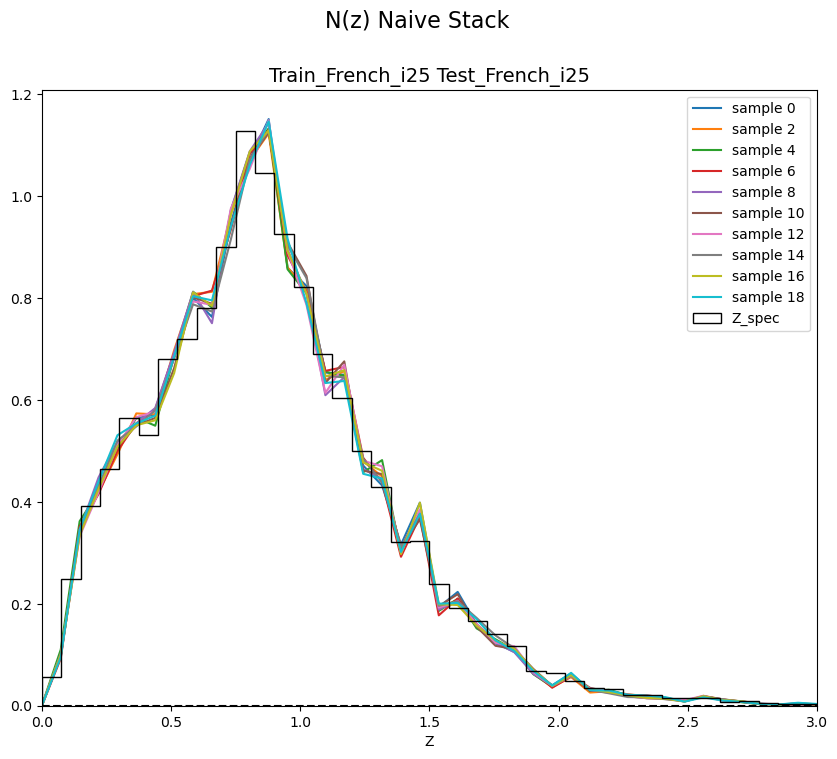

In [38]:
fig, axs = plt.subplots(figsize=(10,8))
for i in range(0, 20, 2):
    newens[i].plot_native(axes=axs, label=f"sample {i}")
axs.plot([0,3],[0,0],'k--')
axs.hist(ztrue,density=True,histtype='step',bins=np.linspace(0,3,41),color='black',label='Z_spec')
axs.set_xlim(0,3)
axs.set_xlabel('Z')
axs.legend(loc='upper right')
axs.set_title(f'Train_{train}_i{mag_train} Test_{test}_i{mag_test}',fontsize=14)
plt.suptitle('N(z) Naive Stack',fontsize=16)
#plt.savefig(f'/home/iago/ic_cosmo/plots/Nz_Train{train}_i{mag_train} Test{test}_i{mag_test}_u')

Text(0.5, 0.98, 'N(z) Naive Stack')

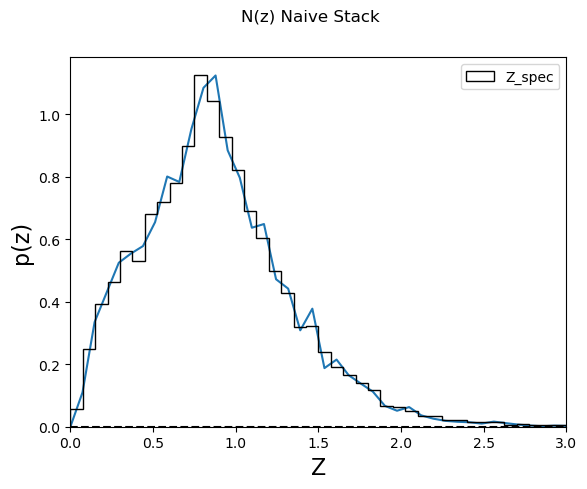

In [39]:
naive_nz = qp.read(f"NaiveStack_NZ_Test{test}_i{mag_test}.hdf5")
naive_nz.plot_native(xlim=(0,3))
plt.plot([0,3],[0,0],'k--')
plt.hist(ztrue,density=True,histtype='step',bins=np.linspace(0,3,41),color='black',label='Z_spec')
plt.xlabel('Z')
plt.legend(loc='upper right')
plt.suptitle('N(z) Naive Stack')

### VarInfStackSummarizer

In [46]:
runner=VarInfStackSummarizer.make_stage(name=f'test_varinf_{test}_i{mag_test}', zmin=0.0,zmax=3.0,nzbins=25, niter=10, nsamples=20,
                                    output="sampletest.hdf5", single_NZ=f"varinf_NZ_Test{test}_i{mag_test}.hdf5")

In [47]:
%%time
varinf_results = runner.summarize(result)

Process 0 running estimator on chunk 0 - 40540
Inserting handle into data store.  output_test_varinf_French_i25: inprogress_sampletest.hdf5, test_varinf_French_i25
Inserting handle into data store.  single_NZ_test_varinf_French_i25: inprogress_varinf_NZ_TestFrench_i25.hdf5, test_varinf_French_i25
CPU times: user 1.93 s, sys: 208 ms, total: 2.14 s
Wall time: 2.15 s


In [48]:
vens = varinf_results.data
vens

<Axes: xlabel='redshift', ylabel='p(z)'>

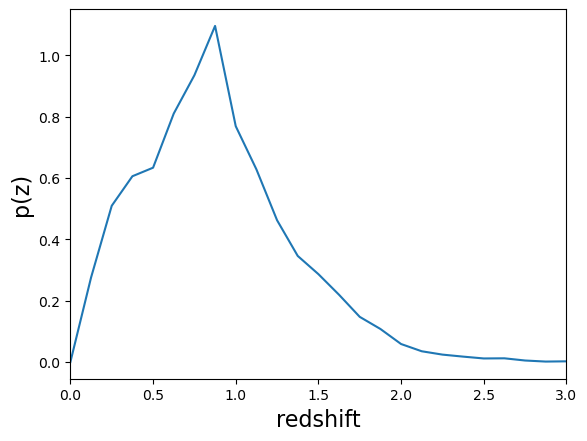

In [50]:
varinf_nz = qp.read(f"varinf_NZ_Test{test}.hdf5")
varinf_nz.plot_native(xlim=(0,3))

## Plots 

### For one result

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


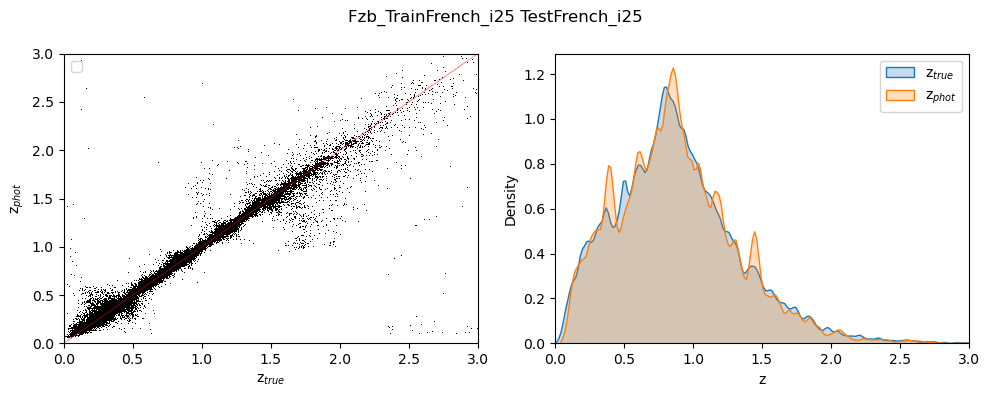

In [43]:

plot_old_valid(zphot,ztrue,f'Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')#,path_to_save=f'/home/iago/ic_cosmo/plots/scatter_Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')


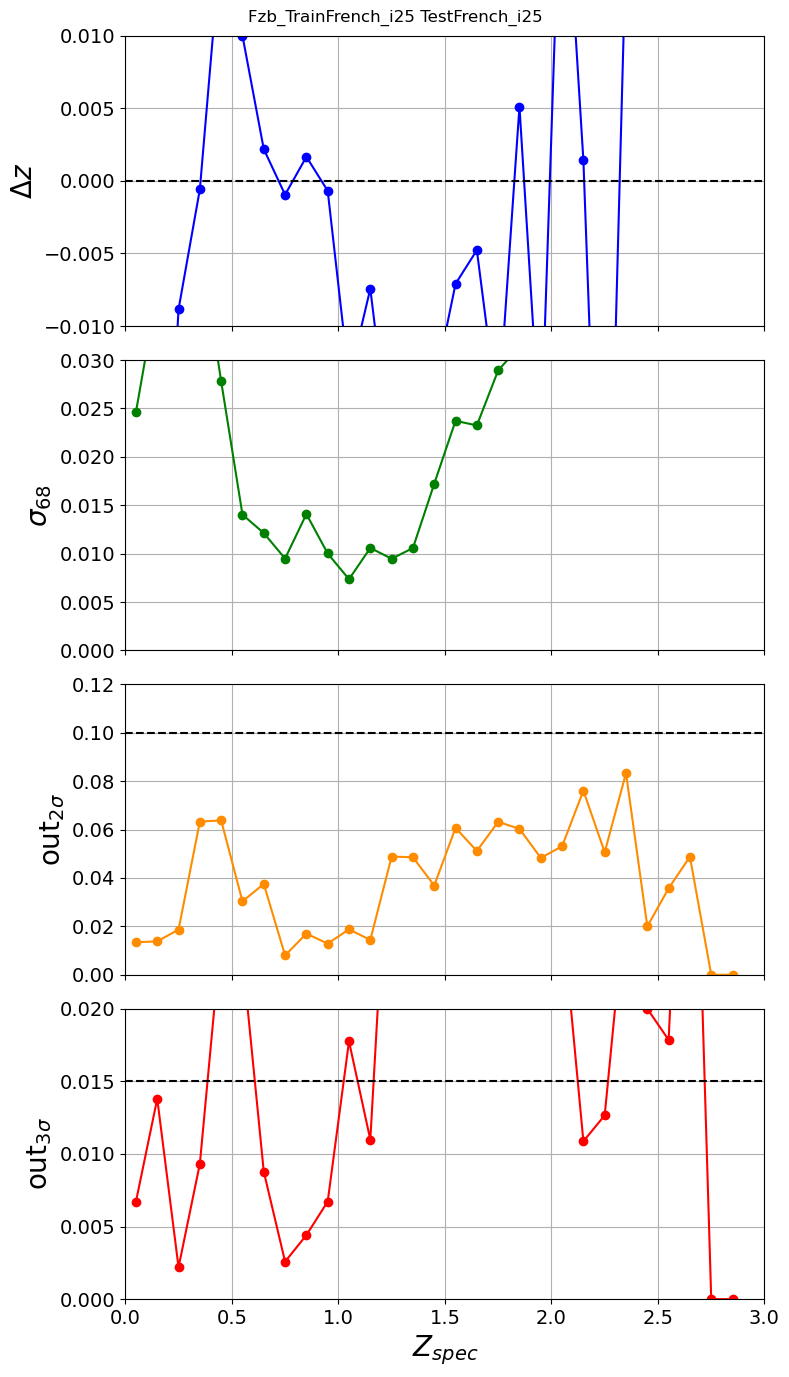

In [45]:

plot_metrics(ztrue,zphot,3,initial=0,title=f'Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')#,path_to_save=f'/home/iago/ic_cosmo/plots/metrics_Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')


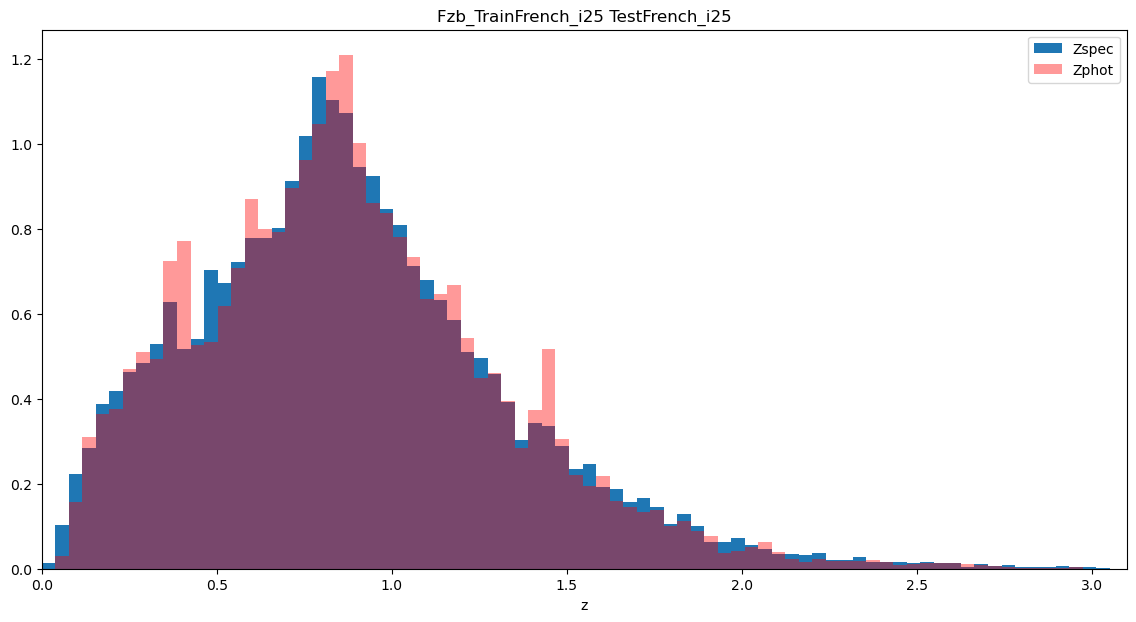

In [46]:
bins=np.linspace(0,z_max,80)
plt.figure(figsize=(14,7))
y = plt.hist(ztrue,bins=bins,label='Zspec', density=True)
t = plt.hist(zphot,bins=bins,label='Zphot', alpha=0.4, density=True,color='red')
#t = plt.hist(zphot_,bins=zgrid,label='Zphot_mixed', histtype = 'step', density=True)
plt.title(f'Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')
plt.xlabel('z')
plt.xlim(0,3.1)
plt.legend()
#plt.savefig(f'/home/iago/ic_cosmo/plots/hist_Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')

### For two results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


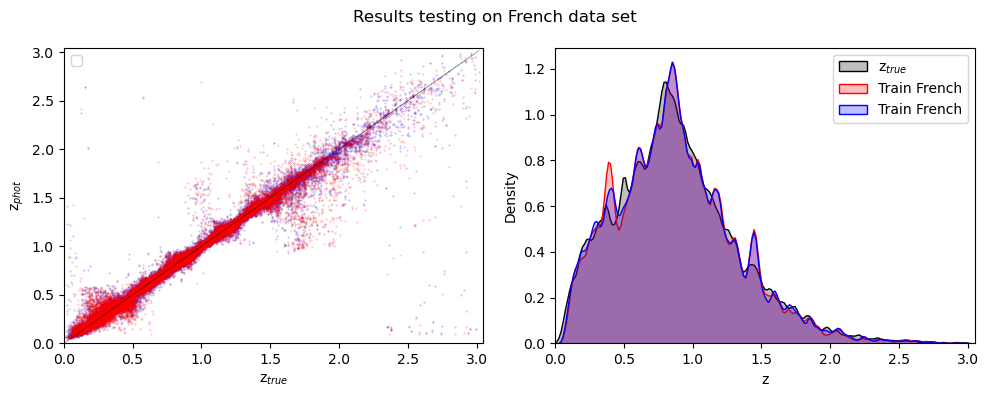

In [36]:
plot_old_valid_comparation(photoz1=zphot1,photoz=zphot2,title=f'Results testing on {test2} data set',photoz1name=f'Train {train1}'
                           ,photozname=f'Train {train2}',ztrue=ztrue,
                          )#path_to_save=f'/home/iago/ic_cosmo/plots/scatter_Fzb_Train{train1}_i{mag_train1} Test{test1}_i{mag_test1}')

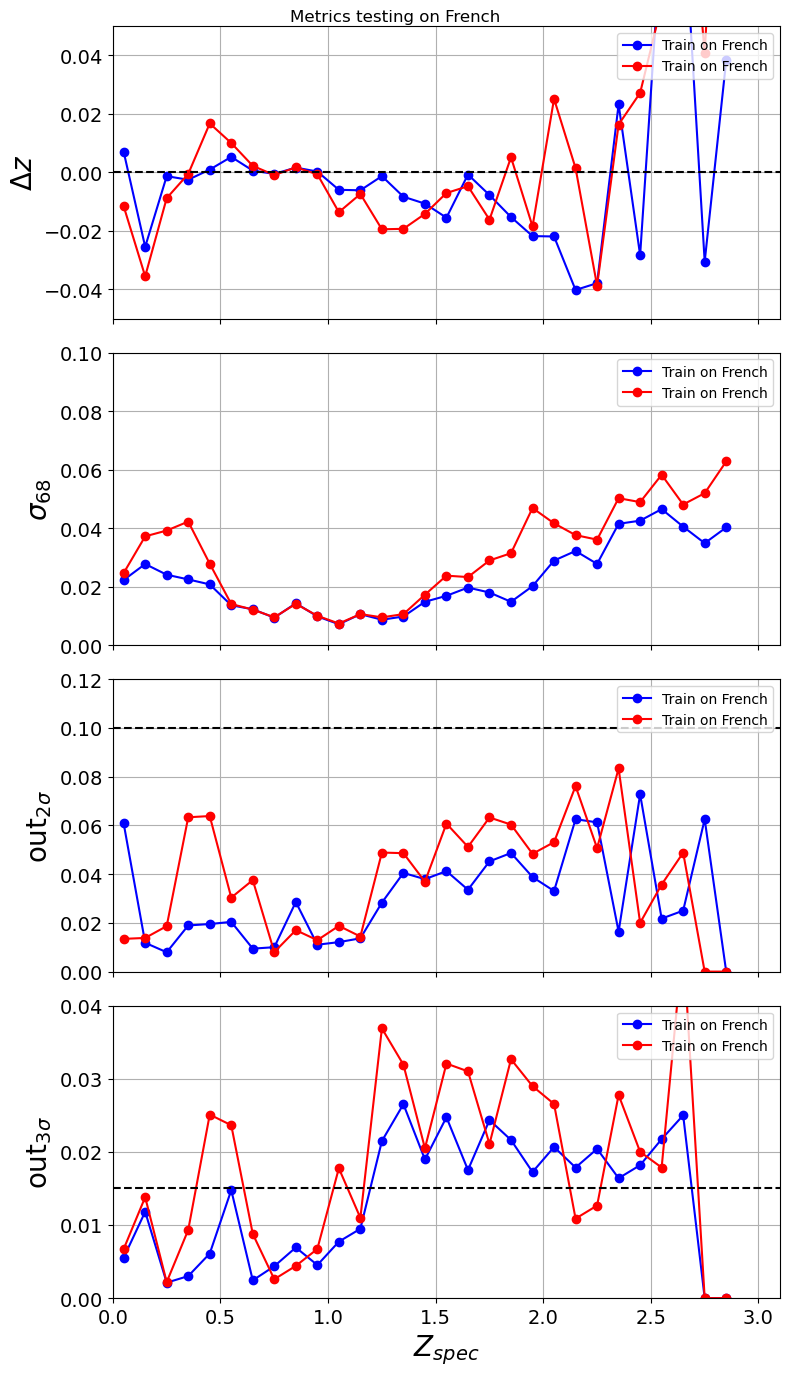

In [35]:
plot_metrics_comparation(ztrue,zphot1,zphot2,initial=0,maximum=3,name1=f'Train on {train1}',name2=f'Train on {train2}',title=f'Metrics testing on {test2}'
                        )#,path_to_save=f'/home/iago/ic_cosmo/plots/metrics_Fzb_Train{train1}_i{mag_train1} Test{test1}_i{mag_test1}')

### Metrics for distributions

In [26]:
pitobj = PIT(result(), ztrue)
quant_ens = pitobj.pit
metamets = pitobj.calculate_pit_meta_metrics()
metamets

{'ad': Anderson_ksampResult(statistic=1537.10712907153, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001),
 'cvm': CramerVonMisesResult(statistic=380.2540812602791, pvalue=1.0512631010151097e-07),
 'ks': KstestResult(statistic=0.07795915831642239, pvalue=0.0, statistic_location=0.2947458481599784, statistic_sign=-1),
 'outlier_rate': 0.027356593689792538}

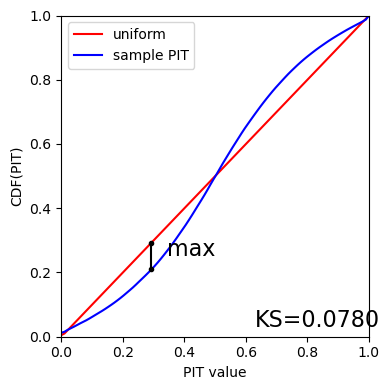

In [27]:
ks_plot(pitobj)

In [28]:
cdelossobj = CDELoss(result.data, zgrid, ztrue)

In [29]:
cde_stat_and_pval = cdelossobj.evaluate()
print(f"CDE loss of this sample: {cde_stat_and_pval.statistic:.2f}") 

CDE loss of this sample: -14.06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 6min 58s, sys: 1.94 s, total: 7min
Wall time: 7min


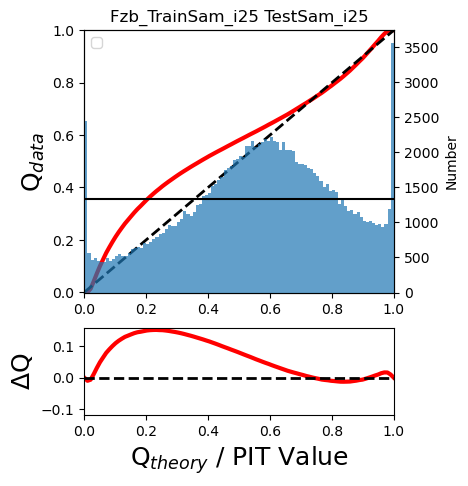

In [30]:
%%time
plot_pit_qq(pdfs,zgrid,ztrue,title=f'Fzb_Train{train}_i{mag_train} Test{test}_i{mag_test}')

### Extra plots

In [79]:
catalog=french

In [76]:
catalog = french[french['mag_i_lsst']<24]
ztrue = catalog['redshift']

In [77]:
vm=[0.09,0.17,0.29,0.47,0.56,0.69]
va=[0.14,0.26,0.4,0.55,0.65,0.81]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


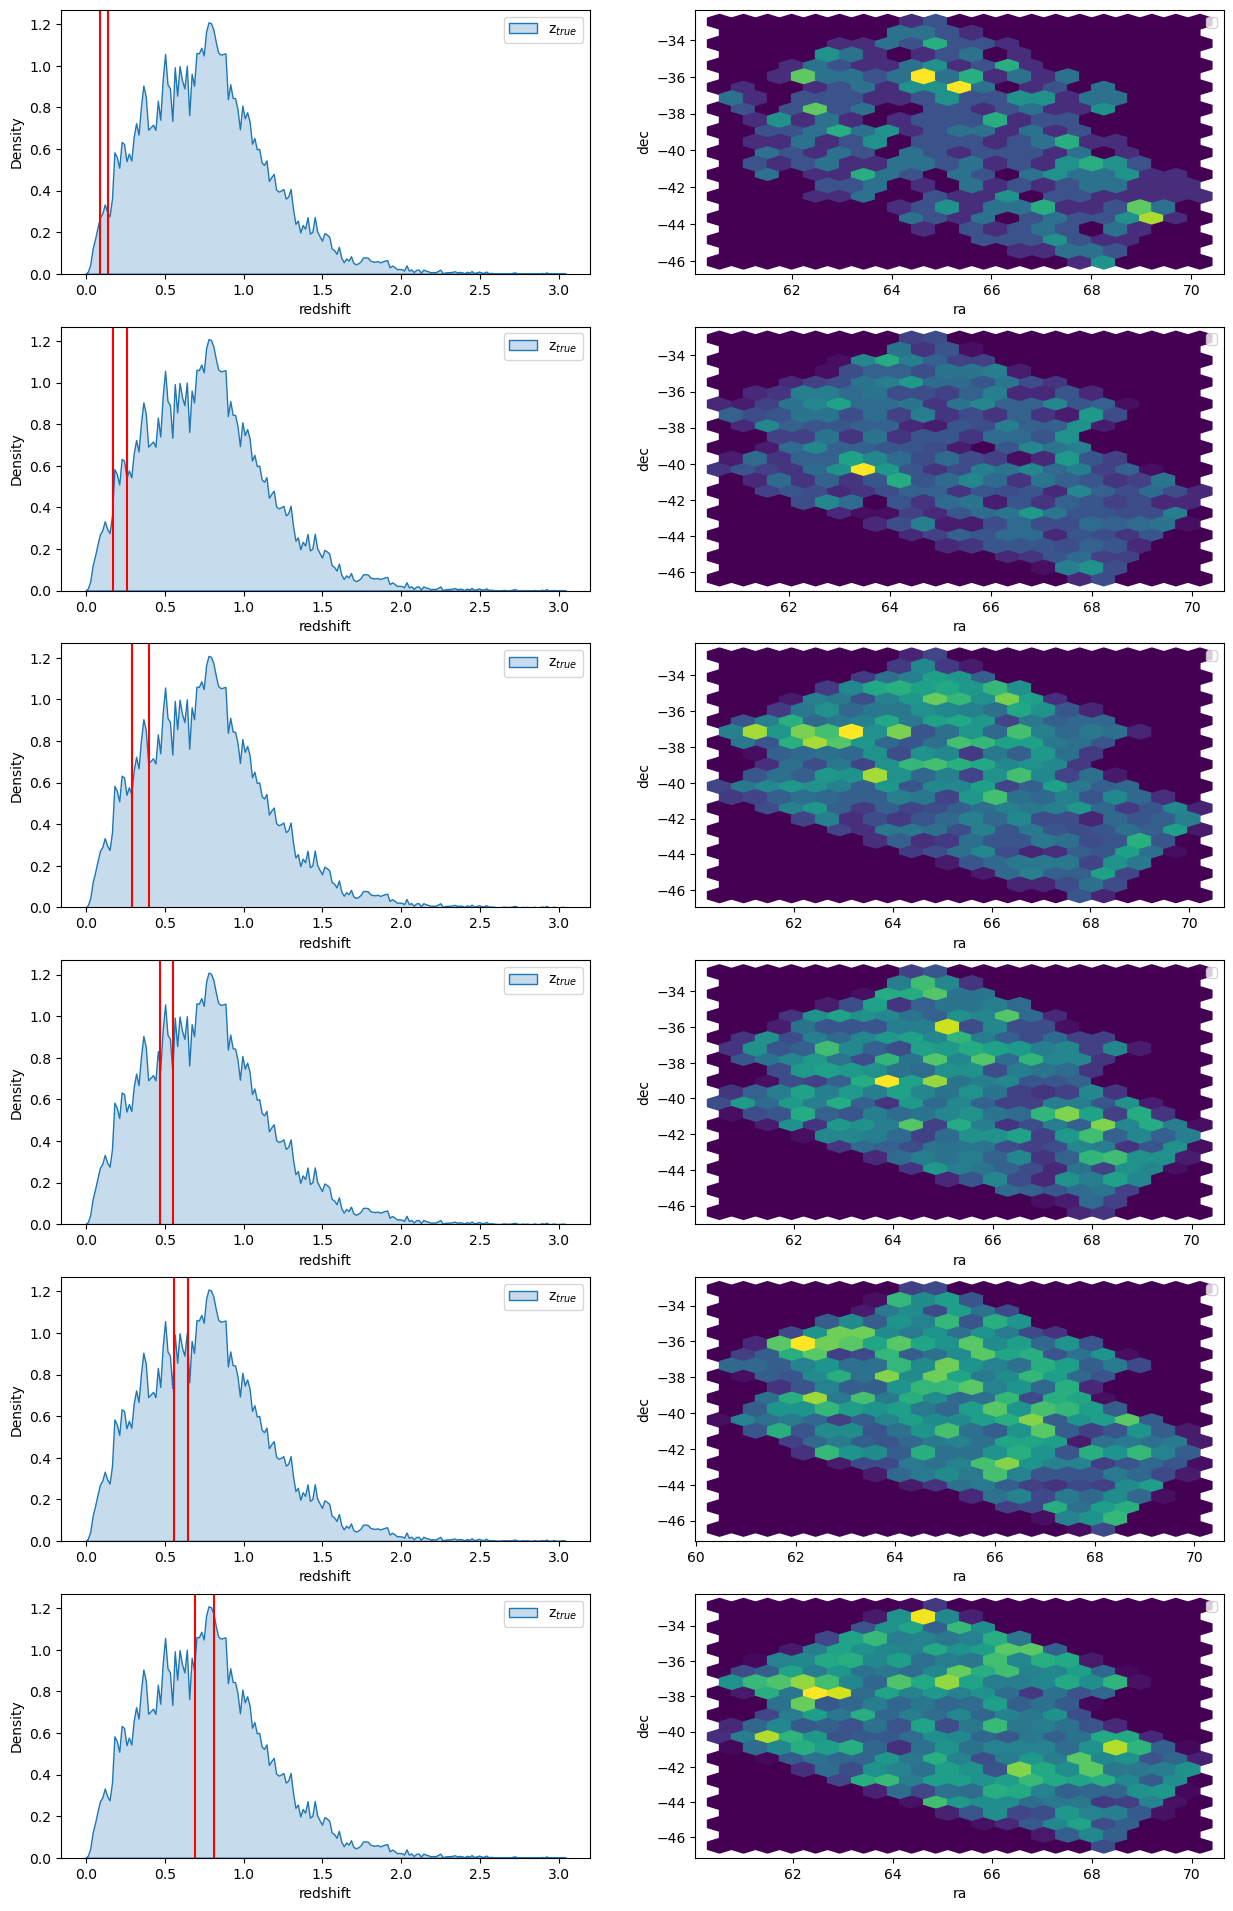

In [78]:
j=1
plt.figure(figsize=(15,24))

for i in range(len(vm)):


    plt.subplot(6,2,j)
    t = sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.1)
    plt.legend()
    plt.axvline(vm[i],color='red')
    plt.axvline(va[i],color='red')
    j+=1

    plt.subplot(6,2,j)
    part = catalog[(catalog['redshift']>vm[i])&(catalog['redshift']<va[i])]
    plt.hexbin(part['ra'],part['dec'],gridsize=20)
    #plt.scatter(catalog['ra'],catalog['dec'],color='blue',s=3,alpha=0.07)
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.legend()
    j+=1

#plt.savefig('/home/iago/ic_cosmo/plots/LSS_plot_hist.png')
plt.show()

In [80]:
ra = catalog['ra']*np.pi/180
dec = catalog['dec']*np.pi/180

In [81]:
ztrue = catalog['redshift']

In [82]:
x = ztrue*np.cos((ra**2+dec**2)**0.5)
y = ztrue*np.sin((ra**2+dec**2)**0.5)

Text(0.5, 1.0, 'Possible LSS in French data')

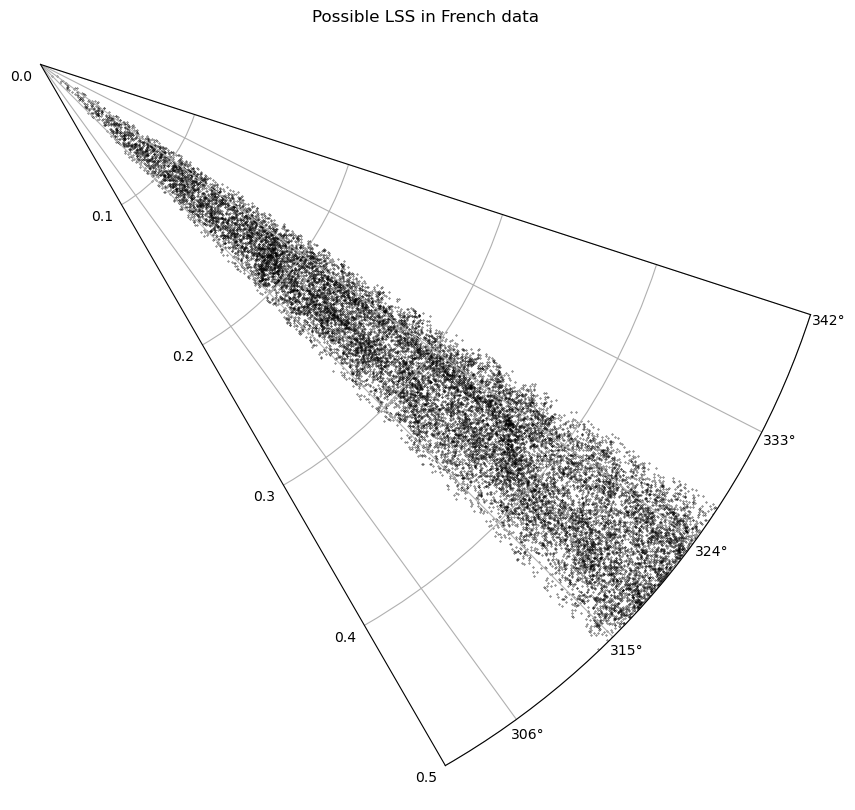

In [105]:
plt.figure(figsize=(10,10))
plt.subplot(111, polar=True)  # Criando um subplot polar
plt.scatter(dec, ztrue,s=0.09,color='black')
plt.xlim(np.pi*10/6,np.pi*19/10)
plt.ylim(0,0.5)
plt.title('Possible LSS in French data')

Text(0.5, 1.0, 'Possible LSS in French data')

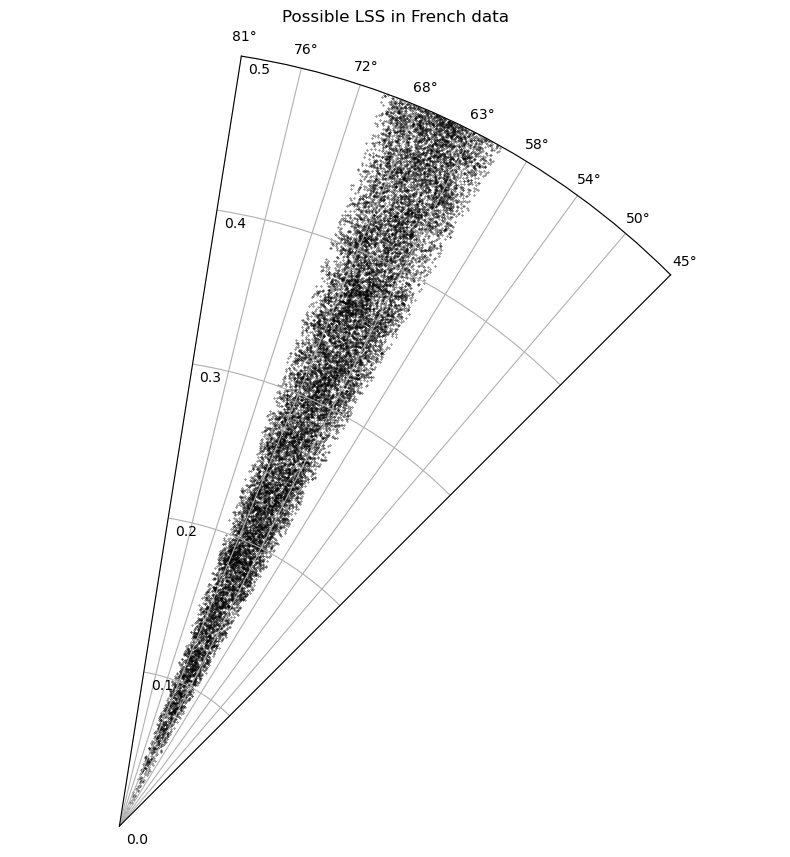

In [106]:
plt.figure(figsize=(10,10))
plt.subplot(111, polar=True)  # Criando um subplot polar
plt.scatter(ra, ztrue,s=0.09,color='black')
plt.xlim(np.pi*9/20,np.pi/4)
plt.ylim(0,0.5)
plt.title('Possible LSS in French data')

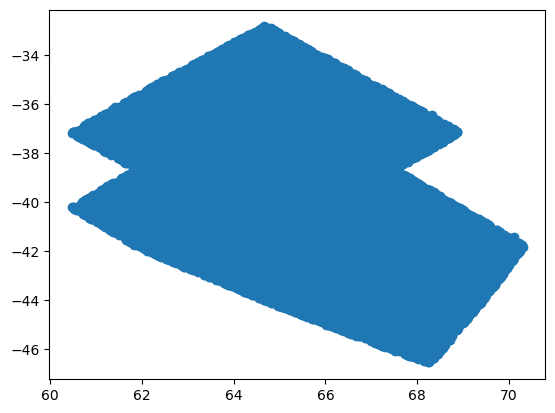

In [20]:
plt.scatter(catalog['ra'],catalog['dec')

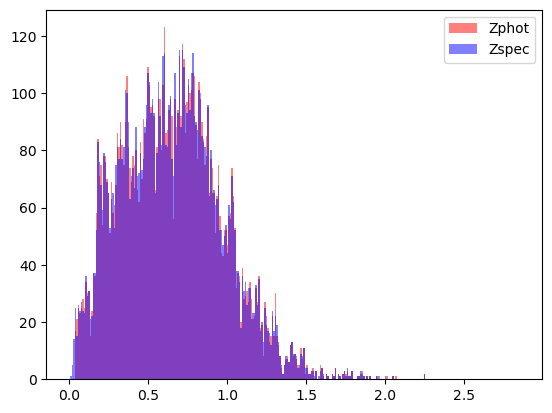

In [86]:
t = plt.hist(zphot,bins=zgrid,label='Zphot',alpha=0.5, color='red')
y = plt.hist(ztrue,bins=zgrid,label='Zspec',alpha=0.5, color='blue')
plt.legend()

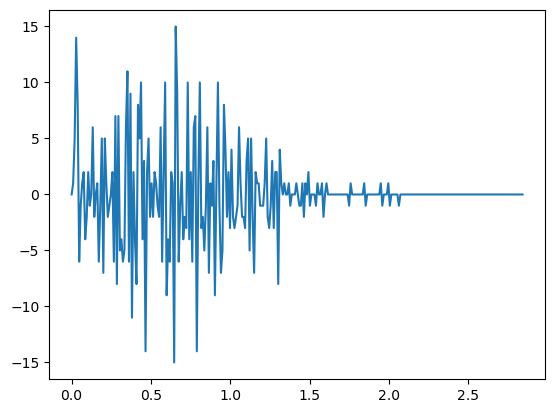

In [87]:
plt.plot(zgrid[:-1],y[0]-t[0])

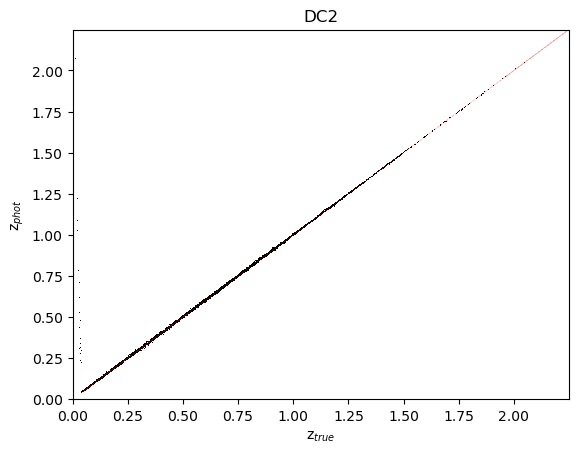

In [88]:
plt.plot(ztrue, zphot, 'k,')
plt.xlim(0,max(zphot))
plt.ylim(0,max(zphot))

plt.plot(zphot,zphot,'r--', linewidth =0.5,alpha=0.4)
plt.xlabel('z$_{true}$')
plt.ylabel('z$_{phot}$')
plt.title('DC2')
#plt.savefig(f'/home/iago/ic_cosmo/plots/i{mag}_scatter.png')
plt.show()

### Gaussiana do erro

In [114]:
deltas = []
for i in range(len(zphot)):
    delta=zphot[i]-ztrue[i]
    deltas.append(delta)

s = np.sort(np.abs(deltas/(1+ztrue)))
sigma68 = s[int(len(s)*0.68)]


In [115]:
from scipy.optimize import curve_fit

In [116]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)


initial_guess = [0.25, 0.0, 1]  # Valores iniciais para amplitude, média e desvio padrão
params, covariance = curve_fit(gaussian, y[1][:-1], y[0], p0=initial_guess)


In [117]:
amplitude, mean, stddev = params

In [118]:
print(f'STD: {stddev}\nMean: {mean}')#### 1.546281008429305

STD: 1.494017269838242
Mean: -0.7601035004190665


(-10.0, 10.0)

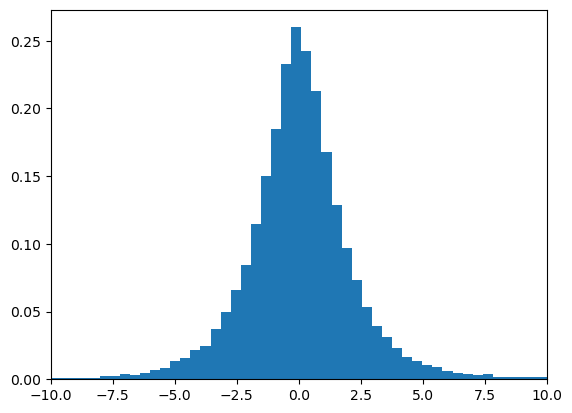

In [119]:
y = plt.hist((zphot-ztrue)/sigma68,bins=800,density=True)
plt.xlim(-10,10)

(-20.0, 20.0)

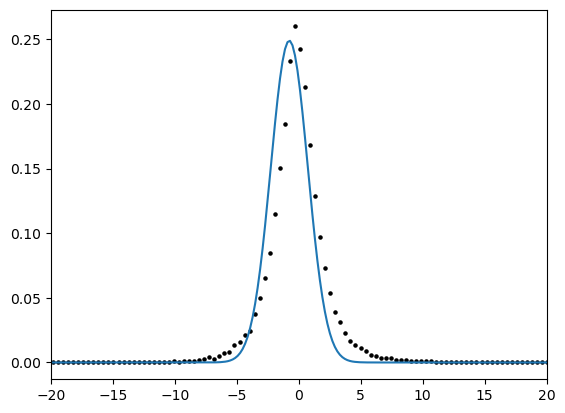

In [121]:
plt.scatter(y[1][:-1],y[0],s=5,color='black')
plt.plot(np.linspace(-20,20,200),gaussian(np.linspace(-20,20,200),amplitude,mean,stddev))
plt.xlim(-20,20)

## Studying the QQ plot (Ignore!!!!!!!!!!!!!!!)


In [ ]:
t = Sample(pdfs,zgrid,ztrue)

In [53]:
pit_array = np.array([t[i].cdf(ztrue[i])[0][0] for i in range(len(t))])

In [54]:
pit_array

array([0.76077626, 0.82780552, 0.31627934, ..., 0.58957507, 0.54218056,
       0.58665723])

(0.0, 0.5)

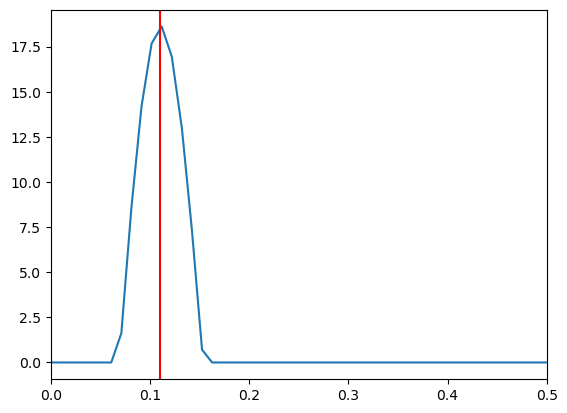

In [55]:
index = 13
plt.plot(zgrid,pdfs[index])
plt.axvline(ztrue[index],color='red')
plt.xlim(0,0.5)

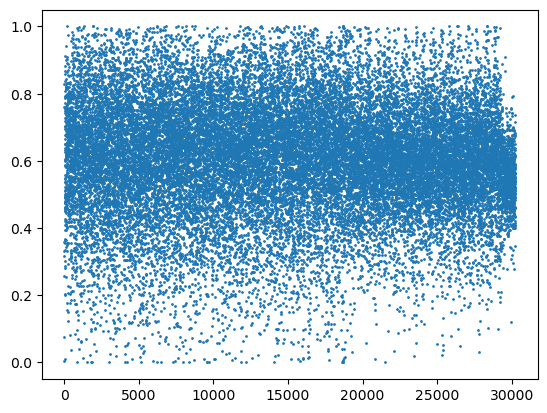

In [56]:
plt.scatter(range(len(pit_array)),pit_array,s=1)

In [57]:
np.quantile(pit_array,np.linspace(0,1,100))

array([0.        , 0.14440046, 0.21419265, 0.25701445, 0.28946486,
       0.31315535, 0.33301929, 0.35037485, 0.3672659 , 0.38231624,
       0.3955739 , 0.40763668, 0.41761042, 0.42694832, 0.43666038,
       0.44552817, 0.45371321, 0.46144406, 0.46829995, 0.47564159,
       0.48200516, 0.48882142, 0.49474227, 0.50043769, 0.50538914,
       0.51066476, 0.51551407, 0.52045216, 0.52548322, 0.53019047,
       0.53490695, 0.53915402, 0.54369484, 0.54794221, 0.55247875,
       0.55680496, 0.56100319, 0.56513422, 0.56894435, 0.57280817,
       0.57669888, 0.5806385 , 0.584827  , 0.58854787, 0.59234799,
       0.59597999, 0.60031788, 0.60383469, 0.60749651, 0.61122567,
       0.61501974, 0.61881084, 0.62269926, 0.62676614, 0.63026404,
       0.63429519, 0.63834477, 0.64202019, 0.64608629, 0.64988639,
       0.65391682, 0.65789751, 0.66189023, 0.66567217, 0.66965827,
       0.6739607 , 0.67830943, 0.68262401, 0.6870161 , 0.69159128,
       0.69603942, 0.70059521, 0.70496494, 0.71023797, 0.71520